# Project 1: Market Risk - VaR, ES, and Copulas

**Names of all group members:**
- William Jallot (william.jallot@epfl.ch)
- Matthias Wyss (matthias.wyss@epfl.ch)
- Antoine Garin (antoine.garin@epfl.ch)

---

## 0 - Setup

Creates necessary folders and sets hyperparameters for the project.

In [1]:
# If a package import fails, install it in your environment, e.g.:
# %pip install yfinance arch copulae statsmodels seaborn

import os
import numpy as np
import copulae
import pandas as pd
import scipy.stats as stats
from pathlib import Path
from itertools import combinations
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf, plot_pacf
from IPython.display import clear_output
from scipy.stats import chi2
from statsmodels.tsa.ar_model import AutoReg
from arch import arch_model
from scipy.stats import norm
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns



import warnings
warnings.filterwarnings('ignore')

# your own script with helper functions, if any
# import utils as U

# Locate the Project 1 directory to this notebook's working directory
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / 'data'
OUT_DIR = PROJECT_DIR / 'output'
for d in [DATA_DIR, OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Parameters
TICKERS = ['AAPL', 'META', 'JPM']
START = '2023-01-01'
END = '2025-06-30'
WINDOW = 252 
CONFIDENCE = [0.95, 0.99]
np.random.seed(0)

print('Project dir:', PROJECT_DIR)
print('Output ->', OUT_DIR)

Project dir: /Users/antoine777/EPFL/QRM/qrm_homework_1
Output -> /Users/antoine777/EPFL/QRM/qrm_homework_1/output


Download and save Adjusted Close for the tickers over the given range into `data/` (CSV per ticker).

In [2]:
import yfinance as yf

print('Downloading data to', DATA_DIR)
for t in TICKERS:
    print(f'  -> {t}')
    df = yf.download(t, start=START, end=END, progress=False, auto_adjust=False)
    if df.empty:
        print(f'     Warning: no data for {t}')
        continue
    out = df.reset_index()
    out = out[['Date', 'Adj Close']]
    out.to_csv(DATA_DIR / f'{t}.csv', index=False)
print('Done.')

  -> AAPL
  -> META
  -> JPM
Done.


Now, load the data back from CSVs

In [3]:
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith('.csv')]
frames = []
for f in files:
    p = os.path.join(DATA_DIR, f)
    df = pd.read_csv(p, parse_dates=['Date'])
    df = df[['Date', 'Adj Close']]
    # Coerce to numeric and drop malformed rows
    df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
    df = df.dropna(subset=['Date', 'Adj Close'])
    df = df.rename(columns={'Adj Close': f.split('.')[0]})
    df = df.set_index('Date').sort_index()
    frames.append(df)
prices = pd.concat(frames, axis=1).dropna(how='all')

print(prices.head(15))

                   JPM        META        AAPL
Date                                          
2023-01-03  125.492226  123.975716  123.211205
2023-01-04  126.662445  126.589615  124.482048
2023-01-05  126.634384  126.162254  123.161942
2023-01-06  129.057602  129.223373  127.693619
2023-01-09  128.524277  128.676743  128.215714
2023-01-10  129.675110  132.175171  128.787064
2023-01-11  130.638794  132.075790  131.506073
2023-01-12  130.507767  135.872375  131.427261
2023-01-13  133.801117  136.140717  132.757187
2023-01-17  131.733444  134.530670  133.919662
2023-01-18  127.775818  132.204987  133.200516
2023-01-19  126.073021  135.315826  133.259598
2023-01-20  126.381744  138.516083  135.820969
2023-01-23  128.430740  142.392212  139.012817
2023-01-24  129.534744  142.262985  140.411728


## 1 - Empirical stylized facts

- a.  Construct log-returns for AAPL, MSFT, JPM; plot series and comment on trends/volatility.
- b.  Estimate correlation functions of returns and absolute returns across assets and lags 0–25; comment.
- c.  QQ plots vs Normal; perform Jarque–Bera test and discuss normality.

### a. Log-returns and plots

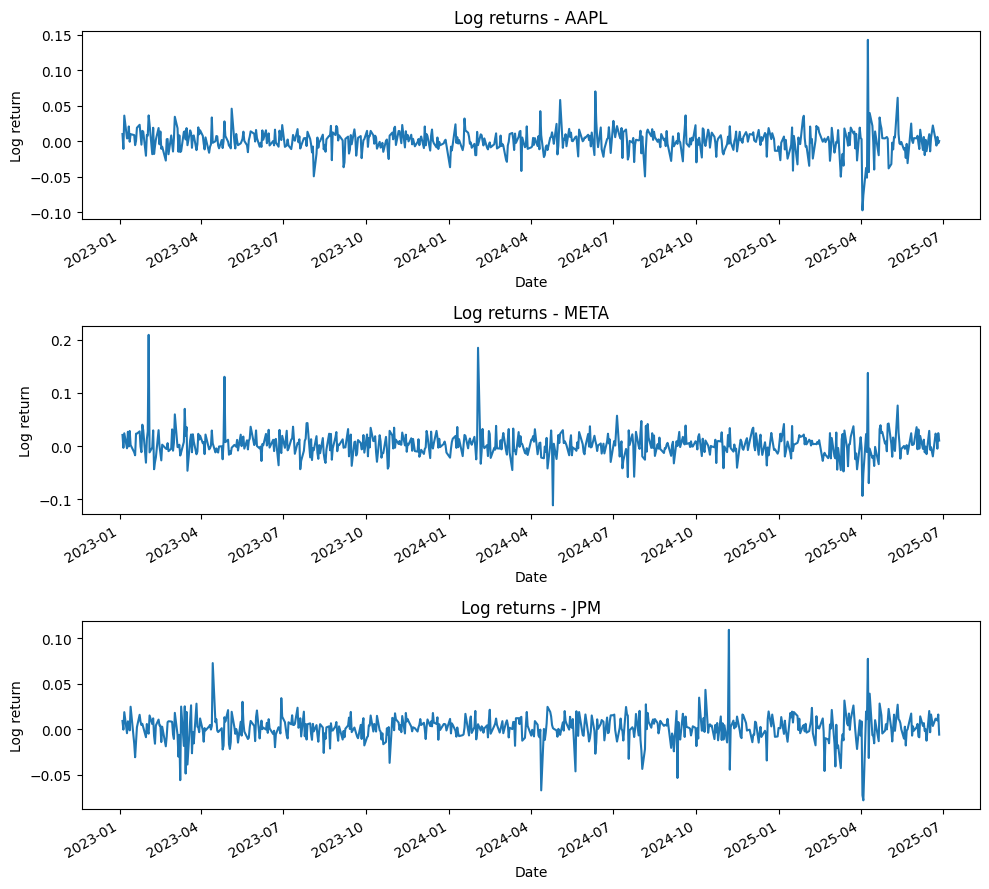

In [4]:
log_returns = np.log(prices).diff().dropna()

# Non-overlapping weekly returns: resample to weekly (Friday close) then compute log returns
# weekly_prices = prices.resample('W-FRI').last()
# weekly_log_returns = np.log(weekly_prices / weekly_prices.shift(1)).dropna()

fig, axs = plt.subplots(len(TICKERS), 1, figsize=(10, 3 * len(TICKERS)))
for i, ticker in enumerate(TICKERS):
    log_returns[ticker].plot(ax=axs[i], title=f"Log returns - {ticker}")
    axs[i].set_ylabel("Log return")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"log_returns_all.png"))
plt.show()

Log-returns show no persistent trend (mean around zero).
Volatility clusters show us that META has the highest volatility, AAPL is moderate, and JPM is the lowest.

### b. Cross-correlation and autocorrelation functions

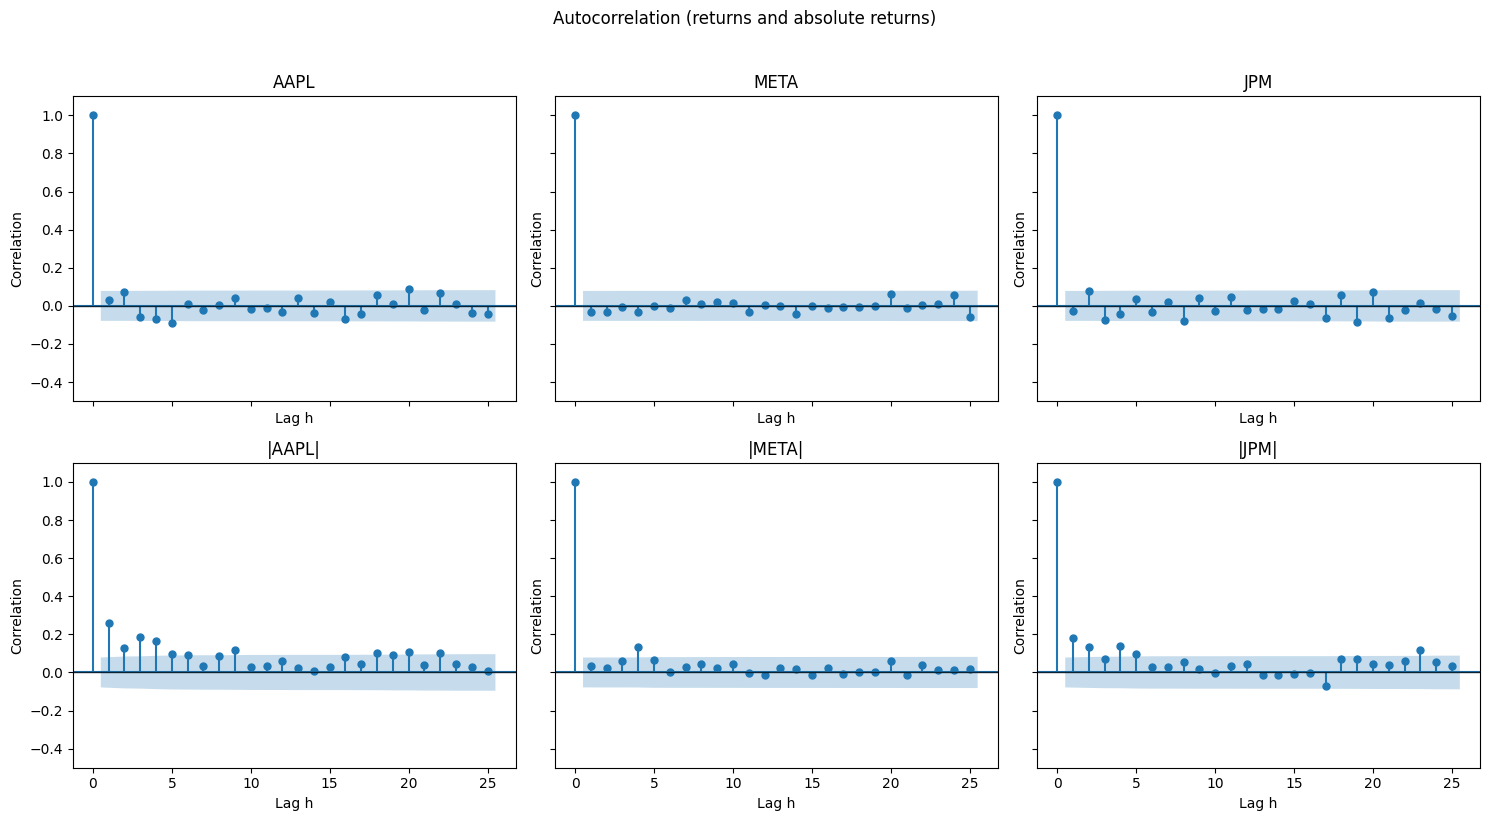

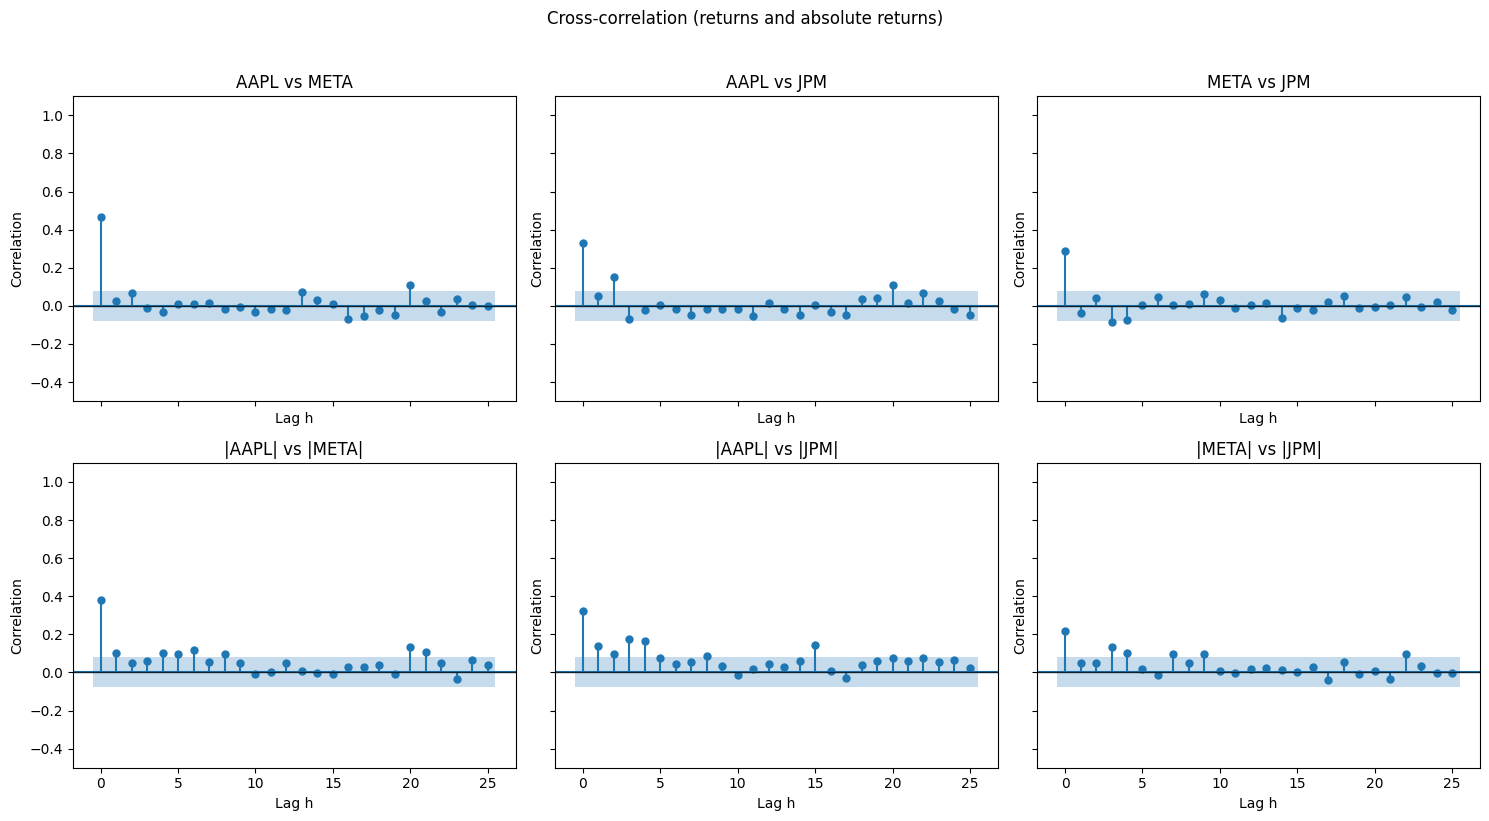

In [5]:
lags = 25

# ACF align per asset only
fig_acf, axs_acf = plt.subplots(2, len(TICKERS), figsize=(5*len(TICKERS), 8), sharex=True, sharey=True)
for j, asset in enumerate(TICKERS):
    s = log_returns[asset].dropna()

    plot_acf(s, lags=lags, ax=axs_acf[0, j])
    axs_acf[0, j].set_title(f"{asset}")
    axs_acf[0, j].axhline(0, lw=1, color="k", alpha=0.7)

    plot_acf(s.abs(), lags=lags, ax=axs_acf[1, j])
    axs_acf[1, j].set_title(f"|{asset}|")
    axs_acf[1, j].axhline(0, lw=1, color="k", alpha=0.7)

for ax in axs_acf.flat:
    ax.set_xlabel("Lag h")
    ax.set_ylabel("Correlation")
    ax.set_ylim(-0.5, 1.1)

fig_acf.suptitle("Autocorrelation (returns and absolute returns)", y=1.02)
fig_acf.tight_layout()
fig_acf.savefig(os.path.join(OUT_DIR, "acf_returns_abs_returns.png"))



# CCF - align per pair
pairs = list(combinations(TICKERS, 2)) # We use combinations to avoid duplicate pairs (A,B) and (B,A) for cross-correlation
fig_ccf, axs_ccf = plt.subplots(2, len(pairs), figsize=(5*len(pairs), 8), sharex=True, sharey=True)

for j, (n, m) in enumerate(pairs):
    # raw returns for direction Corr(n_t, m_{t-h})
    xy = log_returns[[n, m]].dropna()
    x, y = xy[n], xy[m]

    plot_ccf(x, y, lags=lags, ax=axs_ccf[0, j])
    axs_ccf[0, j].set_title(f"{n} vs {m}")
    axs_ccf[0, j].axhline(0, lw=1, color="k", alpha=0.7)

    # absolute returns: take abs on raw series
    xa, ya = x.abs(), y.abs()
    plot_ccf(xa, ya, lags=lags, ax=axs_ccf[1, j])
    axs_ccf[1, j].set_title(f"|{n}| vs |{m}|")
    axs_ccf[1, j].axhline(0, lw=1, color="k", alpha=0.7)

for ax in axs_ccf.flat:
    #ax.set_xlim(0, lags)
    ax.set_xlabel("Lag h")
    ax.set_ylabel("Correlation")
    ax.set_ylim(-0.5, 1.1)

fig_ccf.suptitle("Cross-correlation (returns and absolute returns)", y=1.02)
fig_ccf.tight_layout()
fig_ccf.savefig(os.path.join(OUT_DIR, "ccf_returns_abs_returns.png"))

plt.show()

The autocorrelation of log returns for AAPL, META, and JPM shows almost no correlation after lag 0. This indicates that past returns have little predictive power for future returns, confirming the weak linear dependence typical of stock prices.

Absolute returns exhibit stronger but still week autocorrelations, with lag 1 correlations around 0.2 for AAPL.

Cross-correlations between different stocks’ log returns are moderate at lag 0 (roughly 0.27-0.41) and decay quickly for higher lags. This suggests some contemporaneous co-movement across assets, particularly between AAPL and META, but limited predictive influence across weeks.

Cross-correlations of absolute returns are weaker than the autocorrelations of absolute returns, typically ranging from 0.05 to 0.15 at lag 0. However, they remain positive for most lags, indicating modest volatility spillover across assets.

### c. QQ plots and normality tests

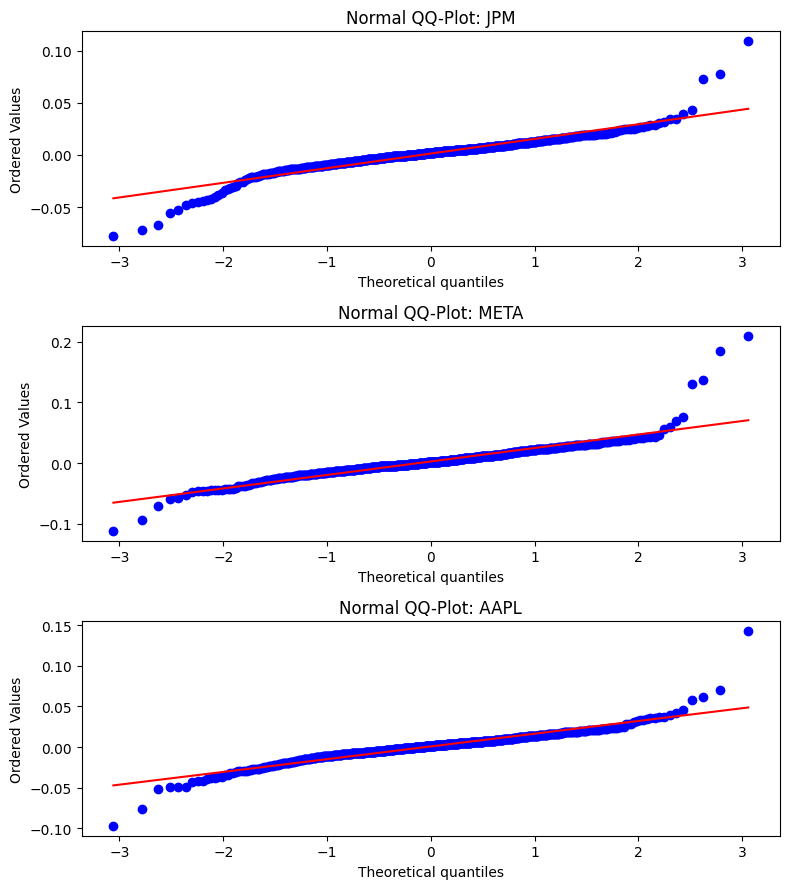

In [6]:
n_assets = len(log_returns.columns)
jarque_bera_results = {}


fig, axes = plt.subplots(n_assets, 1, figsize=(8, 3*n_assets))
for i, ticker in enumerate(log_returns.columns):
        stats.probplot(log_returns[ticker], dist="norm", plot=axes[i])
        axes[i].set_title(f"Normal QQ-Plot: {ticker}")

        jarque_bera_results[ticker] = stats.jarque_bera(log_returns[ticker])

fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "qq_plots.png"))
fig.show()

We can see that across the three assets, the resolut of the QQ plot exhibit the same 'shape'. At the two extremes of the 45 degree line, the theoritical quantiles are below on the left and above on the right. This means our log returns are left skewed (long negative tail) and are fat tailed.

The Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution. It tests, if we can reject the null hypothesis that our returns are normally distributed. If we want to test at 5% level of significance, in case our $p_\text{value}$, the lowest significance at which you can reject, if it is lower than 5% we would reject normality.



In [7]:
for ticker, result in jarque_bera_results.items():
    jb_stat, jb_pvalue = result[0], result[1]
    print(f"Jarque-Bera test for {ticker}:")
    print(f"  JB Statistic: {jb_stat:.4f}")
    print(f"  p-value: {jb_pvalue:.4f}")
    if jb_pvalue < 0.05:
        print("  => Reject the null hypothesis of normality at the 5% significance level.\n")
    else:
        print("  => Fail to reject the null hypothesis of normality at the 5% significance level.\n")

Jarque-Bera test for JPM:
  JB Statistic: 2203.5055
  p-value: 0.0000
  => Reject the null hypothesis of normality at the 5% significance level.

Jarque-Bera test for META:
  JB Statistic: 7608.7725
  p-value: 0.0000
  => Reject the null hypothesis of normality at the 5% significance level.

Jarque-Bera test for AAPL:
  JB Statistic: 3619.2692
  p-value: 0.0000
  => Reject the null hypothesis of normality at the 5% significance level.



## 2 - First-window modeling: VaR, ES, and distributions

Use the first estimation window $W=252$ days on each asset separately with losses $L_t$ = −$R_t$.
Compare: 

- Historical,
- Gaussian,
- Student-t,
- AR(p)+GARCH(1,1) with Normal/Student-t,
- Filtered Historical Simulation (FHS).

We use the first estimation window of length W = 252 days (~1 trading year) for each asset separately.  
Losses are defined as $L_t = -R_t$, so the right tail corresponds to risk.

### a. Historical Simulation (Empirical CDF)

The **empirical cumulative distribution function (CDF)** of losses is:

$$
\hat{F}_L(x) = \frac{1}{W} \sum_{t=1}^W \mathbf{1}_{\{L_t \le x\}}
$$

- **Value-at-Risk (VaR)** at confidence level $\alpha$:

$$
\text{VaR}_\alpha = \inf \{ x : \hat{F}_L(x) \ge \alpha \}
$$

- **Expected Shortfall (ES)**:

$$
\text{ES}_\alpha = \mathbb{E}[L_t \mid L_t \ge \text{VaR}_\alpha] \approx \text{mean of losses ≥ VaR}_\alpha
$$

**Notes:**
- Non-parametric approach: no assumption on the loss distribution.
- Directly based on historical data.

---

In [8]:
def historical_simulation(L, confidence_levels) :
    VaR_hist = {a: np.quantile(L, a) for a in confidence_levels}
    ES_hist = {a: L[L >= VaR_hist[a]].mean() for a in confidence_levels}
    
    out = {
        "VaR": {},
        "ES": {}
    }
    for a in confidence_levels:
        out["VaR"][a] = VaR_hist[a]
        out["ES"][a] = ES_hist[a]
    return out

# We will need this later for Monte Carlo simulations
def historical_sampler(L, M) :
    return np.random.choice(L, replace=True, size=M)

### b. Gaussian (Normal) Distribution

Assume losses are **normally distributed**:

$$
L_t \sim \mathcal{N}(\mu, \sigma^2)
$$

where:

$$
\mu = \text{mean}(L), \quad \sigma = \text{std}(L)
$$

- **Value-at-Risk (VaR)**:

$$
\text{VaR}_\alpha = \mu + \sigma \cdot z_\alpha
$$

where $z_\alpha = \Phi^{-1}(\alpha)$ is the $\alpha$-quantile of the standard normal distribution.

- **Expected Shortfall (ES)**:

$$
\text{ES}_\alpha = \mu + \sigma \frac{\phi(z_\alpha)}{1-\alpha}
$$

with $\phi(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2/2}$, the standard normal density.

**Notes:**
- Closed-form formulas make Gaussian VaR/ES fast to compute.
- Limitation: does not capture fat tails in the loss distribution.

---


In [9]:
def gaussian_normal_distribution(L, confidence_levels) :
    mu, sigma = norm.fit(L)
    VaR_gauss = {a: mu + sigma * norm.ppf(a) for a in confidence_levels}
    ES_gauss = {a: mu + sigma * norm.pdf(norm.ppf(a)) / (1 - a) for a in confidence_levels}
    out = {
        "mu": mu,
        "sigma": sigma,
        "VaR": {},
        "ES": {}
    }
    for a in confidence_levels:
        out["VaR"][a] = VaR_gauss[a]
        out["ES"][a] = ES_gauss[a]
    return out

# We will need this later for Monte Carlo simulations
def gaussian_sampler(L, M) :
     
    mu, sigma = norm.fit(L)
    return np.random.normal(loc=mu, scale=sigma, size=M)

### c. Student-t Distribution

Assume losses follow a **Student-t distribution**:

$$
L_t \sim t_\nu(\mu, \sigma)
$$

where:
- $\nu$ = degrees of freedom (controls tail thickness)
- $\mu$ = location parameter
- $\sigma$ = scale parameter

- **Value-at-Risk (VaR)** at confidence level $\alpha$:

$$
\text{VaR}_\alpha = \mu + \sigma \cdot t_\nu^{-1}(\alpha)
$$

where $t_\nu^{-1}(\alpha)$ is the $\alpha$-quantile of the standard Student-t with $\nu$ degrees of freedom.

- **Expected Shortfall (ES)** for $\nu > 1$:

$$
\text{ES}_\alpha = \mu + \sigma \frac{\nu + \big(t_\nu^{-1}(\alpha)\big)^2}{\nu-1} \cdot \frac{f_\nu(t_\nu^{-1}(\alpha))}{1-\alpha}
$$

where $f_\nu(\cdot)$ is the standard Student-t density.

**Impact of $\nu$:**
- Small $\nu$ → fatter tails → higher VaR and ES (more conservative estimates)
- Large $\nu$ → approaches normal distribution → VaR/ES similar to Gaussian

**Notes:**
- Student-t captures extreme losses better than Gaussian due to fat tails.
- VaR and ES depend strongly on the estimated degrees of freedom $\nu$.


In [10]:
from scipy.stats import t

def student_var_es(L, confidence_levels) : 
    nu, mu_t, sigma_t = t.fit(L)
    VaR_t = {a: mu_t + sigma_t * t.ppf(a, nu) for a in confidence_levels}
    ES_t = {a: mu_t + sigma_t * (nu + (t.ppf(a, nu))**2)/(nu - 1) * t.pdf(t.ppf(a, nu), nu)/(1 - a) for a in confidence_levels}

    out = {
        "VaR": {},
        "ES": {}
    }
    for a in confidence_levels:
        out['nu'] = nu
        out['mu_t'] = mu_t
        out['sigma_t'] = sigma_t
        out["VaR"][a] = VaR_t[a]
        out["ES"][a] = ES_t[a]
    return out

# We will need this later for Monte Carlo simulations
def student_sampler(L, M) :
    nu, mu_t, sigma_t = t.fit(L)
    return t.rvs(df=nu, loc=mu_t, scale=sigma_t, size=M)

### d. Conditional parametric 

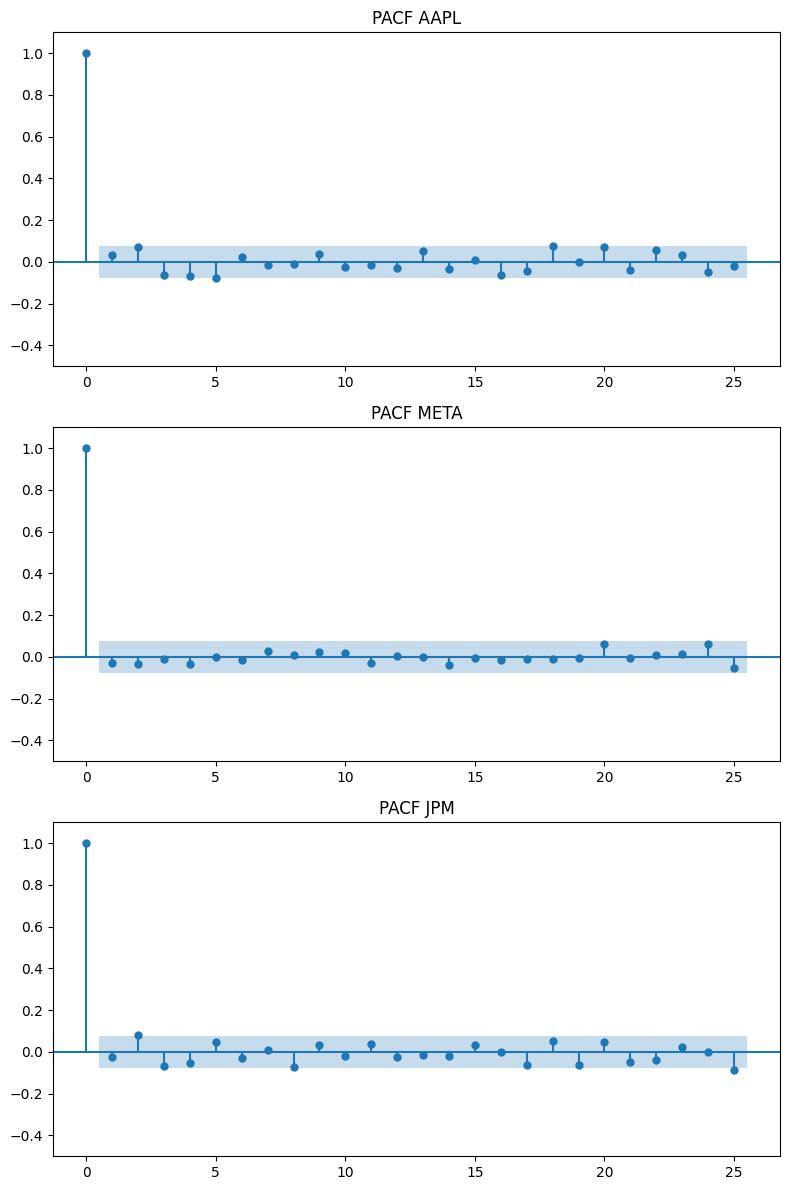

In [11]:
n_assets = len(TICKERS)
fig, axes = plt.subplots(n_assets, 1, figsize=(8, 4 * n_assets))
for i, asset in enumerate(TICKERS):
    plot_pacf(
        log_returns[asset],
        lags=lags,
        ax=axes[i],
        title=f'PACF {asset}'
    )
    axes[i].set_ylim(-0.5, 1.1)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pacf_plots.png"))

After lag 0, most values fluctuate around zero and are within the blue confidence band so we should use an AR(0) model, a pure noise model.

In [12]:
def conditional_parametric_var_es(L, confidence_levels) : 
    res_mean = AutoReg(L, lags=0).fit()
    eps = res_mean.resid

    garch = arch_model(eps, mean='Zero', vol='GARCH', p=1, q=1)
    res_vol = garch.fit(show_warning=False, disp='off')
    vol_forecast = res_vol.forecast(horizon=1)

    sigma_forecast = np.sqrt(vol_forecast.variance.values[-1, 0])
    mean_forecast = res_mean.predict(start=len(L), end=len(L))

    VaR_parametric = {a: mean_forecast.values[0] + sigma_forecast * norm.ppf(a) for a in confidence_levels}
    ES_parametric = {a: mean_forecast.values[0] + sigma_forecast * norm.pdf(norm.ppf(a)) / (1 - a) for a in confidence_levels}
    
    out = {
        "VaR": {},
        "ES": {},
        "mu_forecast": mean_forecast,
        "sigma_forecast": sigma_forecast
    }
    for a in confidence_levels:
        out["VaR"][a] = VaR_parametric[a]
        out["ES"][a] = ES_parametric[a]

    return out

# We will need this later for Monte Carlo simulations
def conditional_parametric_sampler(L, M) :
     
    res_mean = AutoReg(L, lags=0).fit()
    eps = res_mean.resid

    garch = arch_model(eps, mean='Zero', vol='GARCH', p=1, q=1)
    res_vol = garch.fit(show_warning=False, disp='off')
    vol_forecast = res_vol.forecast(horizon=1)

    sigma_forecast = np.sqrt(vol_forecast.variance.values[-1, 0])
    mean_forecast = res_mean.predict(start=len(L), end=len(L))

    return np.random.normal(loc=mean_forecast, scale=sigma_forecast, size=M)

### e. Filtered Historical Simulation

In [13]:
def filtered_historical_simulation(L, alpha_levels, M=1000, random_state=0):
    """
    Filtered Historical Simulation (FHS) on LOSS series L.

    L : array-like or pd.Series
        Losses (positive on bad days, small/possibly negative on good days).
    alpha_levels : list of float
        Confidence levels, e.g. [0.95, 0.99].
    M : int
        Number of Monte Carlo simulations.
    """

    L = pd.Series(L).dropna()

    # AR(0) 
    ar = AutoReg(L, lags=0).fit()
    eps = ar.resid  # residuals of losses

    # GARCH(1,1) on residuals
    garch = arch_model(eps, mean='Zero', vol='GARCH', p=1, q=1)
    garch_res = garch.fit(show_warning=False, disp='off')

    # Conditional volatility and 1-step-ahead forecast
    z_t  = garch_res.std_resid

    h_t1 = garch_res.forecast(horizon=1).variance.iloc[-1, 0]
    sigma_t1 = float(np.sqrt(h_t1))

    # One-step-ahead conditional mean of losses
    mu_t1 = ar.forecast(steps=1).values[0]

    z_star = np.random.choice(z_t, size=M, replace=True)
    eps_t1_star = sigma_t1 * z_star

    #  Simulated next-period losses 
    L_simulated = mu_t1 + eps_t1_star


    # VaR and ES 
    out = {
        "mu_forecast": mu_t1,
        "h_forecast": float(h_t1),
        "r_sims": L_simulated,
        "VaR": {},
        "ES": {}
    }
    
    for a in alpha_levels:
        # a is the confidence level 
        var_a = np.quantile(L_simulated, a)         
        tail = L_simulated[L_simulated >= var_a]
        es_a = float(tail.mean())

        out["VaR"][a] = float(var_a)
        out["ES"][a]  = es_a

    return out

# We will need this later for Monte Carlo simulations
def fhs_sampler(L, M):
    # AR(0) on LOSSES
    ar = AutoReg(L, lags=0).fit()
    eps = ar.resid

    # GARCH(1,1) on residuals
    garch = arch_model(eps, mean='Zero', vol='GARCH', p=1, q=1)
    garch_fitted = garch.fit(show_warning=False, disp='off')

    sigma_t = garch_fitted.conditional_volatility    
    h_t1 = garch_fitted.forecast(horizon=1).variance.values[-1, 0]  # variance
    sigma_t1 = np.sqrt(h_t1)

    # 1-step ahead mean 
    mu_t1 = ar.forecast(steps=1)  # shape (1,)

    # Standardized residuals
    z_t = eps / sigma_t

    # Resampling 
    e_star = np.random.choice(z_t, size=M, replace=True)
    z_t1_star = e_star * sigma_t1

    # Simulated next period
    r_simulated = mu_t1.ravel() + z_t1_star

    return r_simulated

=== Value-at-Risk (VaR) Results ===


Historical  Gaussian  Student-t  Parametric       FHS
Ticker Alpha                                                       
AAPL   95%      0.017587  0.019421   0.018856    0.019611  0.017004
       99%      0.032997  0.028092   0.030775    0.028361  0.028709
META   95%      0.027310  0.035232   0.030027    0.031416  0.024515
       99%      0.043077  0.051512   0.053435    0.046116  0.036081
JPM    95%      0.018300  0.020292   0.017892    0.014451  0.011422
       99%      0.037581  0.029149   0.034001    0.020888  0.024574


=== Expected Shortfall (ES) Results ===


Historical  Gaussian  Student-t  Parametric       FHS
Ticker Alpha                                                       
AAPL   95%      0.026807  0.024738   0.026424    0.024976  0.025728
       99%      0.040701  0.032404   0.039146    0.032712  0.038851
META   95%      0.035920  0.045215   0.045386    0.040429  0.031771
       99%      0.044618  0.059608   0.073637    0.053425  0.039434
JPM    95%      0.030295  0.025723   0.028769    0.018398  0.018972
       99%      0.047523  0.033553   0.050029    0.024089  0.028465

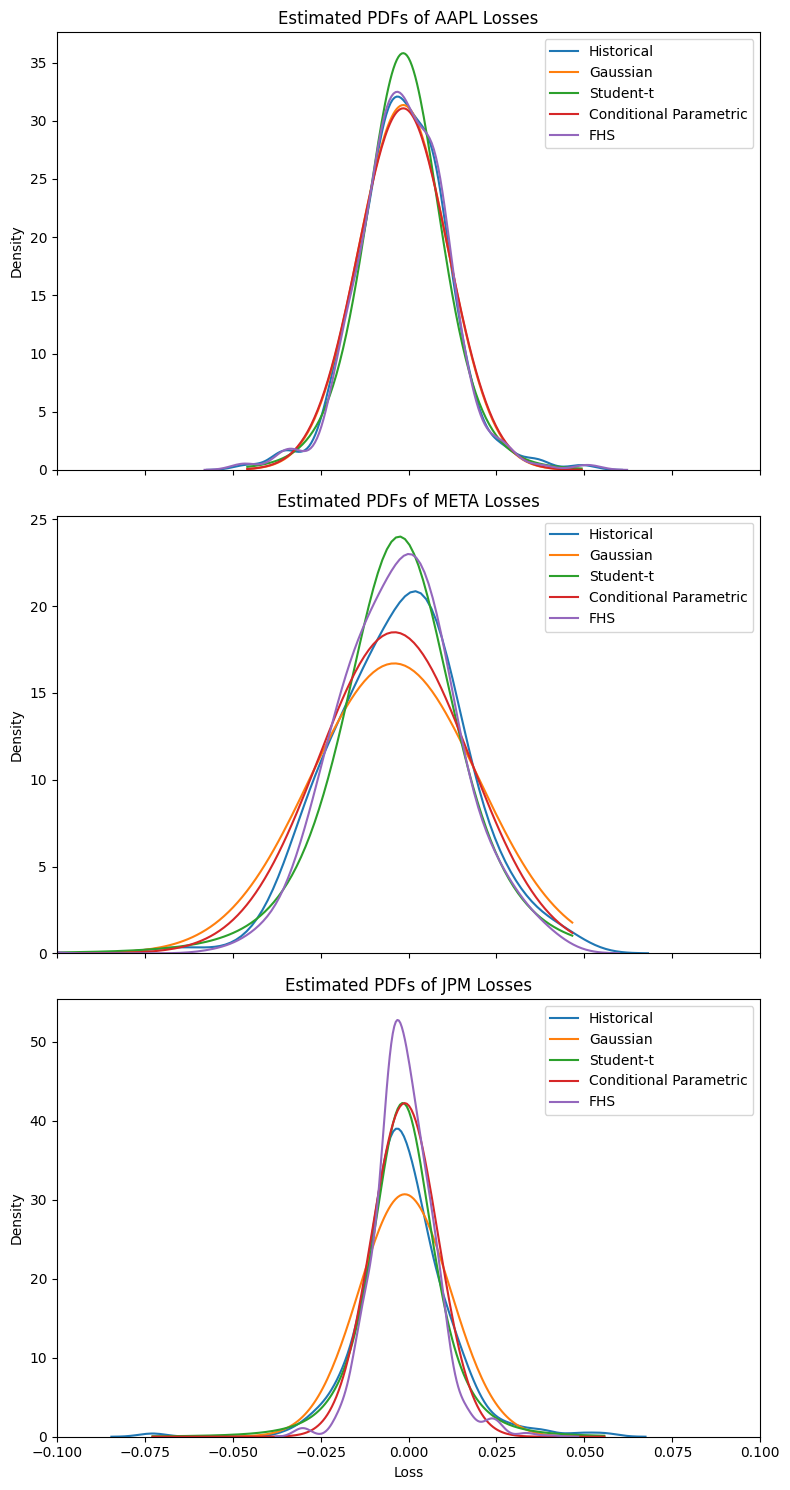

In [14]:
# Plot PDFs for all tickers in one figure
fig, axes = plt.subplots(len(TICKERS), 1, figsize=(8, 5*len(TICKERS)), sharex=True)

# Dictionaries to store results
VaR_results = []
ES_results = []

for i, ticker in enumerate(TICKERS):
    ax = axes[i]  # Select subplot
    ax.set_xlim(-0.1, 0.1)

    # First W observations
    L = -log_returns[ticker].iloc[:WINDOW]

    # === Historical ===
    out_hist = historical_simulation(L, CONFIDENCE)
    sns.kdeplot(L, label='Historical', bw_method=0.3, ax=ax)

    # === Gaussian ===
    out_gauss = gaussian_normal_distribution(L, CONFIDENCE)
    x = np.linspace(L.min(), L.max(), 200)
    ax.plot(x, norm.pdf(x, out_gauss['mu'], out_gauss['sigma']), label='Gaussian')

    # === Student-t ===
    out_t = student_var_es(L, CONFIDENCE)
    ax.plot(x, t.pdf((x - out_t['mu_t'])/out_t['sigma_t'], out_t['nu'])/out_t['sigma_t'], label='Student-t')

    # === Conditional parametric ===
    out_parametric = conditional_parametric_var_es(L, CONFIDENCE)
    ax.plot(x, norm.pdf(x, out_parametric['mu_forecast'], out_parametric['sigma_forecast']), label='Conditional Parametric')
    
    # === Filtered Historical Simulation (FHS) ===
    out_fhs = filtered_historical_simulation(L, CONFIDENCE)
    sns.kdeplot(out_fhs['r_sims'], label='FHS', bw_method=0.3, ax=ax)

    # === Store results ===
    for a in CONFIDENCE:
        VaR_results.append({
            'Ticker': ticker,
            'Alpha': a,
            'Historical': out_hist['VaR'][a],
            'Gaussian': out_gauss['VaR'][a],
            'Student-t': out_t['VaR'][a],
            'Parametric' : out_parametric['VaR'][a],
            'FHS': out_fhs['VaR'][a]
        })
        ES_results.append({
            'Ticker': ticker,
            'Alpha': a,
            'Historical': out_hist['ES'][a],
            'Gaussian': out_gauss['ES'][a],
            'Student-t': out_t['ES'][a],
            'Parametric' : out_parametric['ES'][a],
            'FHS': out_fhs['ES'][a]
        })

    ax.set_title(f"Estimated PDFs of {ticker} Losses")
    ax.set_ylabel("Density")
    ax.legend()

# Convert results to DataFrames
VaR_df = pd.DataFrame(VaR_results).set_index(['Ticker', 'Alpha'])
ES_df = pd.DataFrame(ES_results).set_index(['Ticker', 'Alpha'])

# Format the Alpha index as percentages
VaR_df.index = VaR_df.index.set_levels([VaR_df.index.levels[0],
                                        [f"{int(a*100)}%" for a in VaR_df.index.levels[1]]])
ES_df.index = ES_df.index.set_levels([ES_df.index.levels[0],
                                      [f"{int(a*100)}%" for a in ES_df.index.levels[1]]])

# Display VaR DataFrames
print("=== Value-at-Risk (VaR) Results ===")
display(VaR_df)

# Display ES DataFrames
print("\n=== Expected Shortfall (ES) Results ===")
display(ES_df)

# Save and show plots
axes[-1].set_xlabel("Loss")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_pdfs.png"))
plt.show()

## 3) Rolling-window backtesting of VaR and ES

Use a rolling window of size W to produce 1-step-ahead VaR/ES at 95% and 99% for each method in Exercise 2. Then, implement the following statistical tests:

- VaR backtests: Kupiec POF and Christoffersen independence tests.
- ES backtest: Acerbi–Székely Z1 test.

In [15]:
METHODS = {
    "historical": historical_simulation,
    "gaussian": gaussian_normal_distribution,
    "student": student_var_es,
    "parametric": conditional_parametric_var_es,
    "fhs": filtered_historical_simulation
}


# Put results into a nice rolling forecast dataframe
def rolling_forecast(L, W, methods, confidence):
    results = []
    for name, func in methods.items():
        for metric in ["VaR", "ES"]:
            for a in confidence:
                series = L.rolling(W).apply(
                    lambda loss: func(loss, confidence)[metric][a]
                    )
                series.name = (name, metric, a)
                results.append(series)

    out = pd.concat(results, axis=1)
    # Make it into a nice dataframe to facilitate computations
    out.columns = pd.MultiIndex.from_tuples(out.columns, names=["method", "metric", "alpha"])

    return out.dropna(how="all")

rolling_results = {}
for ticker in TICKERS:
    print(f'Processing {ticker}...')
    L = -log_returns[ticker]
    rolling_results[ticker] = rolling_forecast(L, WINDOW, METHODS, CONFIDENCE)

clear_output()
display(rolling_results)

{'AAPL': method     historical                                gaussian            \
 metric            VaR                  ES                 VaR             
 alpha            0.95      0.99      0.95      0.99      0.95      0.99   
 Date                                                                      
 2024-01-04   0.017587  0.032997  0.026807  0.040701  0.019421  0.028092   
 2024-01-05   0.017587  0.032997  0.026807  0.040701  0.019465  0.028132   
 2024-01-08   0.017587  0.032997  0.026807  0.040701  0.019418  0.028122   
 2024-01-09   0.017587  0.032997  0.026807  0.040701  0.019266  0.027844   
 2024-01-10   0.017587  0.032997  0.026807  0.040701  0.019263  0.027841   
 ...               ...       ...       ...       ...       ...       ...   
 2025-06-23   0.032176  0.050384  0.047979  0.074598  0.033305  0.047010   
 2025-06-24   0.032176  0.050384  0.047979  0.074598  0.033172  0.046849   
 2025-06-25   0.032176  0.050384  0.047979  0.074598  0.033095  0.046767   
 202

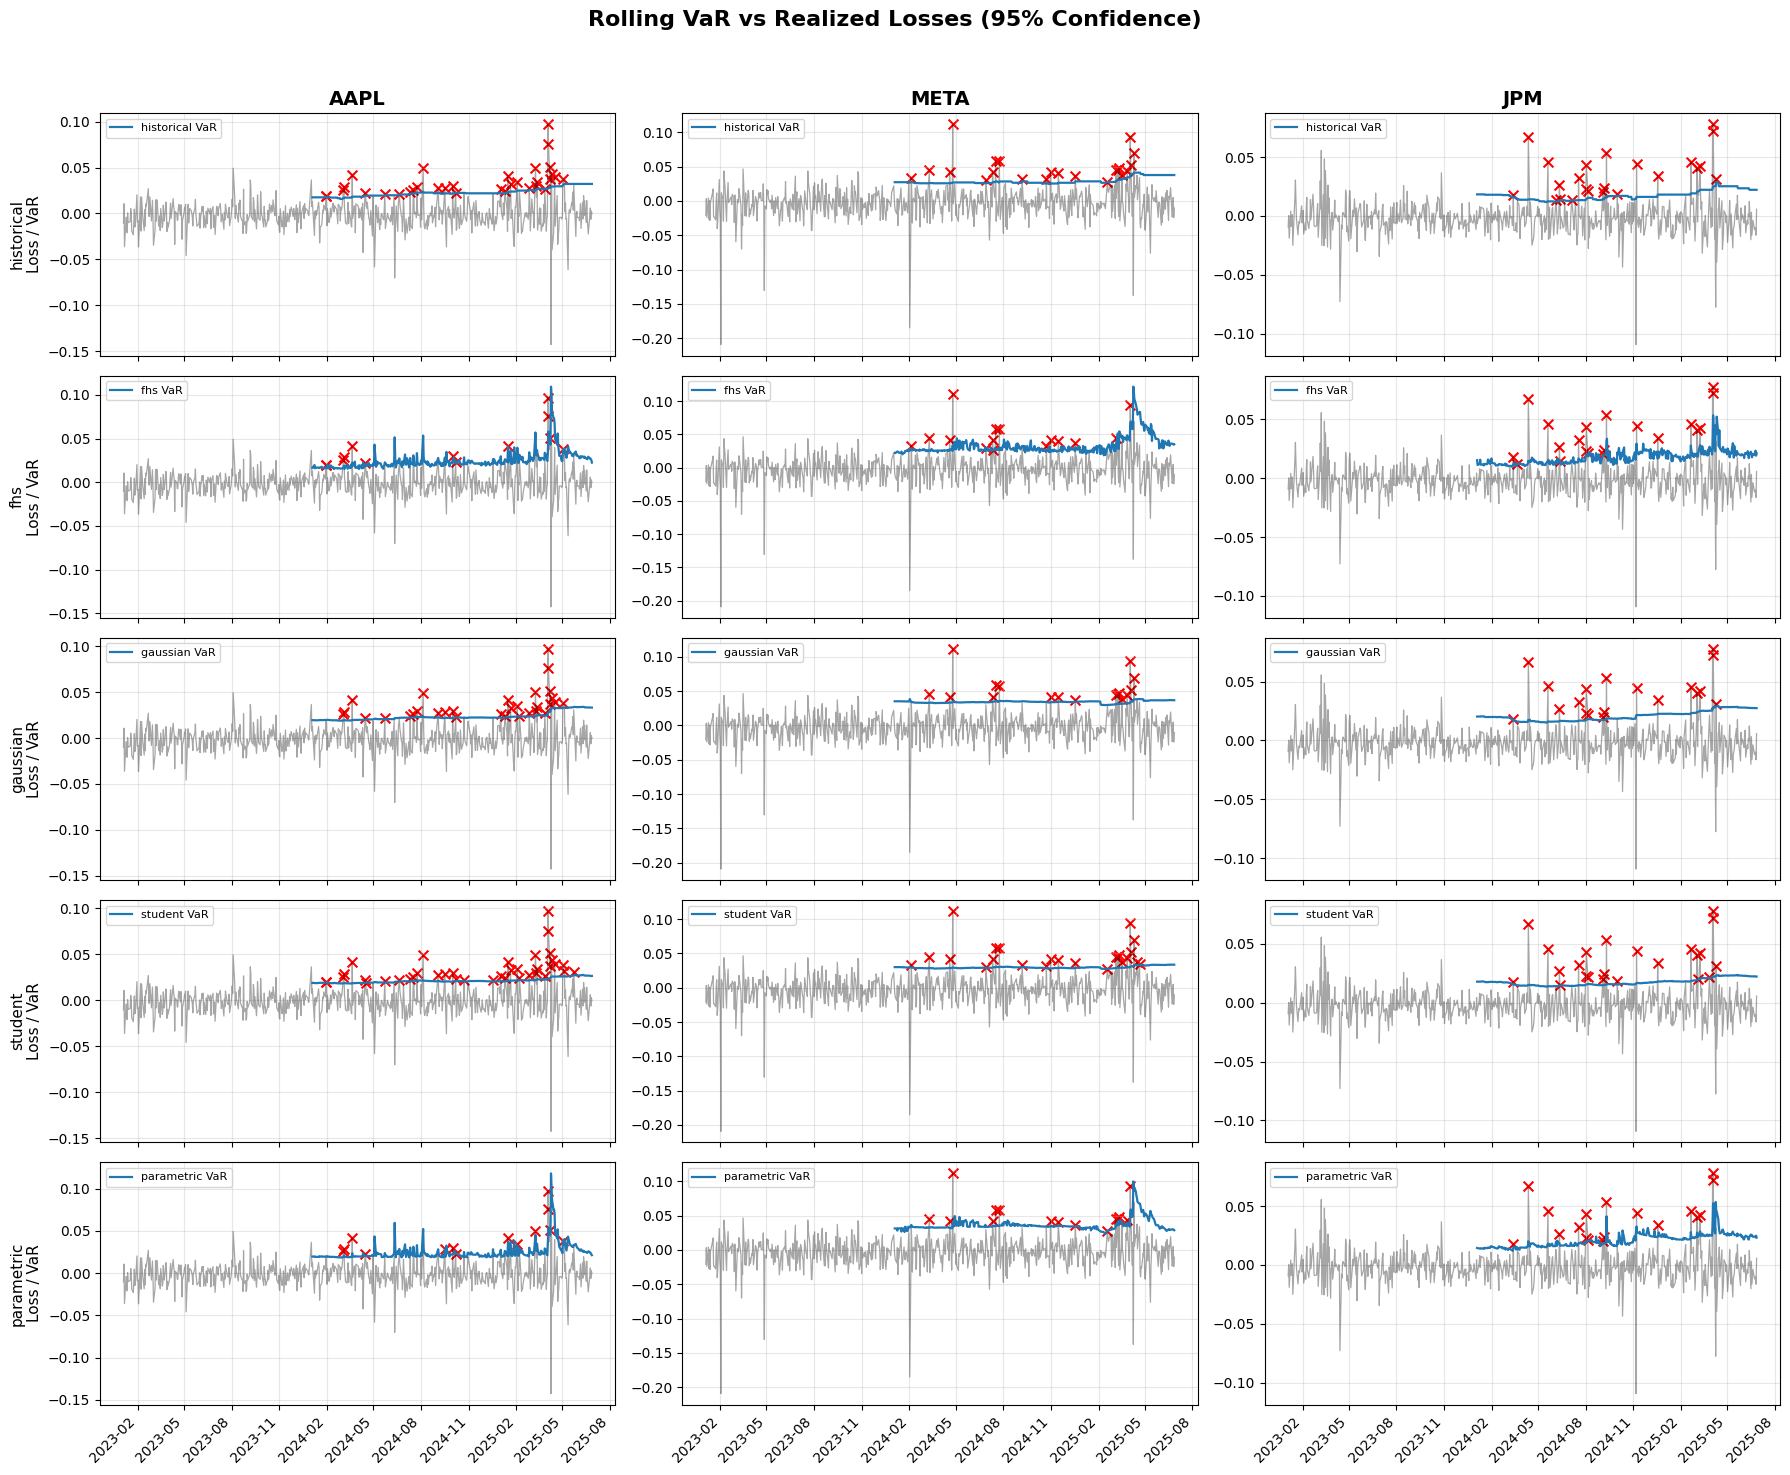

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.dates as mdates

def plot_var_subplots(rolling_results, log_returns, tickers, methods_to_plot, confidence=0.95):

    n_methods = len(methods_to_plot)
    n_tickers = len(tickers)

    fig, axes = plt.subplots(n_methods, n_tickers, figsize=(6*n_tickers, 3*n_methods), sharex=True)

    for i, method in enumerate(methods_to_plot):
        for j, ticker in enumerate(tickers):

            ax = axes[i, j]

            L = -log_returns[ticker].dropna()
            df = rolling_results[ticker]

            VaR_series = df[(method, "VaR", confidence)].dropna()

            # Align loss and VaR indices
            common_idx = L.index.intersection(VaR_series.index)
            L_aligned = L.loc[common_idx]
            V_aligned = VaR_series.loc[common_idx]

            ax.plot(L.index, L.values, color="black", alpha=0.35, linewidth=0.9)
            ax.plot(V_aligned.index, V_aligned.values, linewidth=1.6, label=f"{method} VaR")

            violations = L_aligned > V_aligned
            ax.scatter(
                L_aligned[violations].index, L_aligned[violations].values,
                color="red", marker="x", s=50
            )

            # Titles
            if i == 0:
                ax.set_title(f"{ticker}", fontsize=14, fontweight="bold")
            if j == 0:
                ax.set_ylabel(f"{method}\nLoss / VaR", fontsize=11)

            # Grid
            ax.grid(alpha=0.3)
            ax.legend(fontsize=8, loc="upper left")

            #Prevent overlapping date labels
            if i == n_methods - 1:  # only bottom row shows dates
                ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            else:
                ax.set_xticklabels([])  

    plt.suptitle(f"Rolling VaR vs Realized Losses ({int(confidence*100)}% Confidence)",
                 fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    plt.suptitle(f"Rolling VaR vs Realized Losses ({int(confidence*100)}% Confidence)", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

methods_to_plot = ["historical", "fhs", "gaussian", "student", "parametric"]
methods_to_plot = ["historical", "fhs", "gaussian", "student", "parametric"]

plot_var_subplots(rolling_results=rolling_results, log_returns=log_returns, tickers=TICKERS,methods_to_plot=methods_to_plot, confidence=0.95)

In [17]:
def kupiec_pof_test(VaR_series, L_series, alpha):
    """
    Kupiec (1995) Proportion of Failures (POF) test.
    H0: The observed failure rate equals alpha.
    """

    df = pd.concat([VaR_series, L_series], axis=1)
    df.columns = ['VaR', 'Loss']
    df = df.dropna()

    # Identify breaches
    df['breached'] = df['Loss'] > df['VaR']

    # Compute statistics
    x = df['breached'].sum() 
    n = len(df)
    alpha_hat = x / n

    # Edge cases 
    if alpha_hat == 0 or alpha_hat == 1:
        return np.nan

    # Kupiec POF statistic 
    POF = 2 * np.log(
        ((1 - alpha_hat) / (1 - alpha))**(n - x) *
        (alpha_hat / alpha)**x
    )

    return POF

In [18]:
def christoffersen(VaR_series, L_series):
    """
    Christoffersen (1998) conditional coverage test
    """

    VaR  = pd.Series(VaR_series, name="VaR").astype(float)
    Loss = pd.Series(L_series,  name="Loss").astype(float)
    df = pd.concat([VaR, Loss], axis=1).dropna()

    # Breach indicator 
    df['breached'] = df['Loss'] > df['VaR']

    # Previous breach via shift 
    df['breached_previous'] = df['breached'].shift(1)

    # Keep rows where previous state is defined
    df = df.dropna(subset=['breached_previous'])

    # Transition counts using boolean masks 
    N_0_0 = ((~df['breached']) & (~df['breached_previous'])).sum()
    N_0_1 = (( df['breached']) & (~df['breached_previous'])).sum()
    N_1_0 = ((~df['breached']) & ( df['breached_previous'])).sum()
    N_1_1 = (( df['breached']) & ( df['breached_previous'])).sum()

    N = N_0_0 + N_0_1 + N_1_0 + N_1_1
    if N == 0:
        return np.nan  # not enough transitions

    denom0 = N_0_0 + N_0_1  # times with prev=0
    denom1 = N_1_0 + N_1_1  # times with prev=1
    if denom0 == 0 or denom1 == 0:
        return np.nan

    pi_0 = N_0_1 / denom0                 
    pi_1 = N_1_1 / denom1                 
    p    = (N_0_1 + N_1_1) / N           

    # In case log(0)
    eps = 1e-12
    pi_0 = np.clip(pi_0, eps, 1 - eps)
    pi_1 = np.clip(pi_1, eps, 1 - eps)
    p    = np.clip(p,    eps, 1 - eps)

    L0_log = (N_0_0 + N_1_0) * np.log(1 - p) + (N_0_1 + N_1_1) * np.log(p)
    L1_log = (N_0_0 * np.log(1 - pi_0) + N_0_1 * np.log(pi_0) +
              N_1_0 * np.log(1 - pi_1) + N_1_1 * np.log(pi_1))
    LR_ind = -2 * (L0_log - L1_log)

    return LR_ind

In [19]:
def chi_square_test(t_stat, df, method_name, test_name) :
    print(f'Performing {test_name}')
    p_value = 1 - chi2.cdf(t_stat, df = df)

    print(f'The test statistic and p value for {method_name} are : t_stat {t_stat}, p_value {p_value}')

    if p_value < 0.05 :
        print(f'Reject the null hypothesis at 5% significance level for {method_name}.\n')
    else :
        print(f'Fail to reject the null hypothesis at 5% significance level for {method_name}.\n')
    return p_value

In [20]:
confidence = 0.95
alpha = 1 - confidence  
METHODS = ['historical', 'gaussian', 'student', 'parametric', 'fhs']
result = pd.DataFrame(columns = ['Ticker', 'Method', 'test_statistic_pof', 'p_value_pof', 'test_statistic_cd_coverage', 'p_value_cd_coverage'])
for ticker in rolling_results.keys() :
    print('-'*115)
    for method in METHODS:
        ticker_df = rolling_results[ticker][method]['VaR'][confidence]
        ticker_loss = -log_returns[ticker]

        df = pd.DataFrame({"Loss": ticker_loss, "VaR": ticker_df})
        # Shift loss series to align with VaR forecasts
        df["Loss"] = df["Loss"].shift(-1)   
        df = df.dropna()
        POF = kupiec_pof_test(df['VaR'], df['Loss'], alpha)
        INC = christoffersen(df['VaR'], df['Loss'])
        result = pd.concat([
            result,
            pd.DataFrame([{
                'Ticker': ticker,
                'Method': method,
                'test_statistic_pof': POF,
                'p_value_pof': chi_square_test(
                    POF, df=1, method_name=f'{ticker} - {method}', test_name='POF test'
                ),
                'test_statistic_cd_coverage': INC + POF,
                'p_value_cd_coverage': chi_square_test(
                    INC + POF, df=2, method_name=f'{ticker} - {method}', test_name='Christoffersen conditional coverage test'
                )
            }])
    ], ignore_index=True)


print('-'*115)

-------------------------------------------------------------------------------------------------------------------
Performing POF test
The test statistic and p value for AAPL - historical are : t_stat 11.077879426957683, p_value 0.0008736365182221428
Reject the null hypothesis at 5% significance level for AAPL - historical.

Performing Christoffersen conditional coverage test
The test statistic and p value for AAPL - historical are : t_stat 14.674895396266155, p_value 0.000650709209637168
Reject the null hypothesis at 5% significance level for AAPL - historical.

Performing POF test
The test statistic and p value for AAPL - gaussian are : t_stat 7.455309864811115, p_value 0.006324958979089912
Reject the null hypothesis at 5% significance level for AAPL - gaussian.

Performing Christoffersen conditional coverage test
The test statistic and p value for AAPL - gaussian are : t_stat 9.212069488879282, p_value 0.009991358151714258
Reject the null hypothesis at 5% significance level for AAP

In [21]:
result.pivot(index=['Ticker', 'Method'], columns=[], values=['test_statistic_pof', 'p_value_pof', 'test_statistic_cd_coverage', 'p_value_cd_coverage'])

test_statistic_pof  p_value_pof  \
Ticker Method                                        
AAPL   historical           11.077879     0.000874   
       gaussian              7.455310     0.006325   
       student              20.031440     0.000008   
       parametric            4.467393     0.034548   
       fhs                   6.386015     0.011502   
META   historical            1.073138     0.300238   
       gaussian              0.131441     0.716943   
       student               1.580101     0.208746   
       parametric            0.371915     0.541962   
       fhs                   0.341395     0.559025   
JPM    historical            1.580101     0.208746   
       gaussian              0.014105     0.905462   
       student               1.073138     0.300238   
       parametric            0.014105     0.905462   
       fhs                   1.580101     0.208746   

                   test_statistic_cd_coverage  p_value_cd_coverage  
Ticker Method                                                       
AAPL   historical                   14.674895             0.000651  
       gaussian                      9.212069             0.009991  
       student                      22.561494             0.000013  
       parametric                    4.474896             0.106731  
       fhs                           6.507141             0.038636  
META   historical                    1.273273             0.529069  
       gaussian                      0.186728             0.910862  
       student                       1.812080             0.404121  
       parametric                    1.759884             0.414807  
       fhs                           0.375235             0.828932  
JPM    historical                    4.263305             0.118641  
       gaussian                      2.720578             0.256587  
       student                       4.188907             0.123138  
       parametric                    2.720578             0.256587  
       fhs                           2.631006             0.268339

In [22]:
def es_backtest_z1(VaR_series, ES_series, Loss_series):
    """
    Implements the MSCI Z1 Expected Shortfall backtest (Acerbi & Szekely, 2014)
    Using the 'X_t' definition: P&L (positive=profit, negative=loss)
    """
    VaR = pd.Series(VaR_series, name="VaR", dtype="float64")
    ES = pd.Series(ES_series, name="ES", dtype="float64")
    Loss = pd.Series(Loss_series, name="Loss", dtype="float64")

    df = pd.concat([VaR, ES, Loss], axis=1).dropna()

    df["I_t"] = (df["Loss"] > df["VaR"]).astype(int)

    N_T = int(df["I_t"].sum())

    if N_T == 0:
        return np.nan  # No breaches, Z1 undefined

    Z_1 = ( (df["Loss"] * df["I_t"]) / df["ES"] ).sum() / N_T - 1

    return Z_1


def monte_carlo_es_backtest_z1(VaR_series, ES_series, Loss_series, sampler, window, M=1000):
    """
    VaR_series, ES_series : pandas.Series
        Out-of-sample VaR/ES forecasts, same index (e.g. from rolling_forecast).
    Loss_series : pandas.Series
        Full loss series (in-sample + out-of-sample), NOT truncated.
    sampler(window_array, M) -> np.ndarray of shape (M,)
        Function that, given a window of losses, returns M simulated losses.
    window : int
        Rolling window length used to estimate VaR/ES.
    M : int
        Number of Monte Carlo paths.

    Returns
    -------
    Z1 : np.ndarray of shape (M,)
        Monte Carlo distribution of the ES backtest statistic Z1.
    """


    # Make sure everything is aligned and sorted
    VaR = VaR_series.sort_index()
    ES  = ES_series.reindex(VaR.index)  # ensure same index/order

    # Full loss series (sorted)
    Loss_series = Loss_series.sort_index()
    x = np.asarray(Loss_series, dtype=float)
    loss_index = Loss_series.index

    idx = VaR.index    # out-of-sample dates
    T = len(idx)

    sims = np.empty((M, T), dtype=float)

    # For each date, build the same rolling window used to estimate VaR/ES
    for j, date in enumerate(idx):
        loc = loss_index.get_loc(date)  # position of this date in the full loss series

        # Window of length `window` ending at `date`
        w = x[loc - window + 1 : loc + 1]
        draws = sampler(w, M)
        sims[:, j] = draws

    # Compute Z1 for each simulated path
    Z1 = np.empty(M, dtype=float)
    for m in range(M):
        sim_series = pd.Series(sims[m], index=idx)
        Z1[m] = es_backtest_z1(VaR, ES, sim_series)

    return Z1

In [23]:
sampler = {'historical':  historical_sampler, 'gaussian': gaussian_sampler, 'student': student_sampler, 'parametric':  conditional_parametric_sampler, 'fhs': fhs_sampler}

result = pd.DataFrame(columns=['Ticker', 'Method', 'Z1_stat', 'p_value_es_backtest'])
confidence = 0.95

for ticker in rolling_results.keys():
    print('-' * 115)

    # Full loss series for this ticker (same as in rolling_forecast)
    ticker_loss = -log_returns[ticker].dropna()
    for method in METHODS:
        ticker_df_es  = rolling_results[ticker][method]['ES'][confidence]
        ticker_df_var = rolling_results[ticker][method]['VaR'][confidence]

        Z_1_simulated = monte_carlo_es_backtest_z1(ticker_df_var, ticker_df_es, ticker_loss, sampler[method], window=WINDOW, M=1000)

        real_Z1 = es_backtest_z1(ticker_df_var, ticker_df_es, ticker_loss)

        p_value = (Z_1_simulated >= real_Z1).sum() / len(Z_1_simulated)

        result = pd.concat([result,pd.DataFrame([{'Ticker': ticker, 'Method': method, 'Z1_stat': real_Z1, 'p_value_es_backtest': p_value}])], ignore_index=True)

        print(f'The test statistic and p value for {ticker} - {method} are : 'f'Z1_stat {real_Z1}, p_value {p_value}')
        if p_value < 0.05:
            print(f'Reject the null hypothesis at 5% significance level for {ticker} - {method}.\n')
        else:
            print(f'Fail to reject the null hypothesis at 5% significance level for {ticker} - {method}.\n')

-------------------------------------------------------------------------------------------------------------------
The test statistic and p value for AAPL - historical are : Z1_stat 0.017972986802935242, p_value 0.364
Fail to reject the null hypothesis at 5% significance level for AAPL - historical.

The test statistic and p value for AAPL - gaussian are : Z1_stat 0.16692768613849096, p_value 0.0
Reject the null hypothesis at 5% significance level for AAPL - gaussian.

The test statistic and p value for AAPL - student are : Z1_stat -0.027739257529522665, p_value 0.552
Fail to reject the null hypothesis at 5% significance level for AAPL - student.

The test statistic and p value for AAPL - parametric are : Z1_stat 0.040016025748123685, p_value 0.193
Fail to reject the null hypothesis at 5% significance level for AAPL - parametric.

The test statistic and p value for AAPL - fhs are : Z1_stat -0.09963856573779684, p_value 0.95
Fail to reject the null hypothesis at 5% significance level f

In [24]:
result.pivot(index=['Ticker', 'Method'], columns=[], values=['Z1_stat'	,'p_value_es_backtest'])

Z1_stat  p_value_es_backtest
Ticker Method                                   
AAPL   historical  0.017973                0.364
       gaussian    0.166928                0.000
       student    -0.027739                0.552
       parametric  0.040016                0.193
       fhs        -0.099639                0.950
META   historical  0.057959                0.263
       gaussian    0.241137                0.000
       student     0.043682                0.270
       parametric  0.081289                0.046
       fhs         0.066835                0.280
JPM    historical  0.104376                0.163
       gaussian    0.534150                0.000
       student     0.299154                0.026
       parametric  0.283411                0.000
       fhs         0.029065                0.500

## 4) Copula fitting (first window)

- a. Visualize dependence in returns and copula space using pseudo-observations.
- b. Fit Gaussian and t copulas; report parameters.
- c. Simulate from fitted copulas and map to empirical marginals; compare with original returns.

In [25]:
# TODO

# Use copulae package for copula fitting and sampling
# cop = copulae.elliptical.GaussianCopula(dim=len(TICKERS))
# cop.fit(data)
# samples = cop.random(n)

### a. Pseudo-observations and dependence visualization

Pseudo-observations transform the marginal distributions to uniform $[0,1]$ using empirical ranks:

$$
U_{t,i} = \frac{\text{rank}(R_{t,i})}{W+1}, \quad t = 1,\ldots,W
$$

This allows us to visualize the **pure dependence structure** (copula) separately from marginal behavior.

In [26]:
# Extract the first estimation window (W=252 observations) across assets
returns_window = log_returns.iloc[:WINDOW].copy()

# Compute pseudo-observations (empirical quantiles)
def compute_pseudo_obs(data):
    """
    Transform data to pseudo-observations U in [0,1] using empirical ranks.
    U_{t,i} = rank(R_{t,i}) / (n+1)
    """
    n = len(data)
    U = data.rank() / (n + 1)
    return U

pseudo_obs = compute_pseudo_obs(returns_window)

print("Pseudo-observations (first 5 rows):")
print(pseudo_obs.head())
print(f"\nShape: {pseudo_obs.shape}")
print(f"Range: [{pseudo_obs.min().min():.4f}, {pseudo_obs.max().max():.4f}]")

Pseudo-observations (first 5 rows):
                 JPM      META      AAPL
Date                                    
2023-01-04  0.806324  0.814229  0.790514
2023-01-05  0.418972  0.375494  0.134387
2023-01-06  0.936759  0.869565  0.988142
2023-01-09  0.288538  0.359684  0.588933
2023-01-10  0.794466  0.881423  0.600791

Shape: (252, 3)
Range: [0.0040, 0.9960]


In [27]:
returns_window.describe()

,JPM,META,AAPL
count,252.000000,252.000000,252.000000
mean,0.001085,0.004061,0.001509
std,0.013022,0.023936,0.012750
min,-0.055657,-0.046545,-0.049211
25%,-0.004990,-0.009337,-0.006280
50%,0.002284,0.001695,0.001713
75%,0.007869,0.014698,0.008760
max,0.072795,0.209307,0.045859


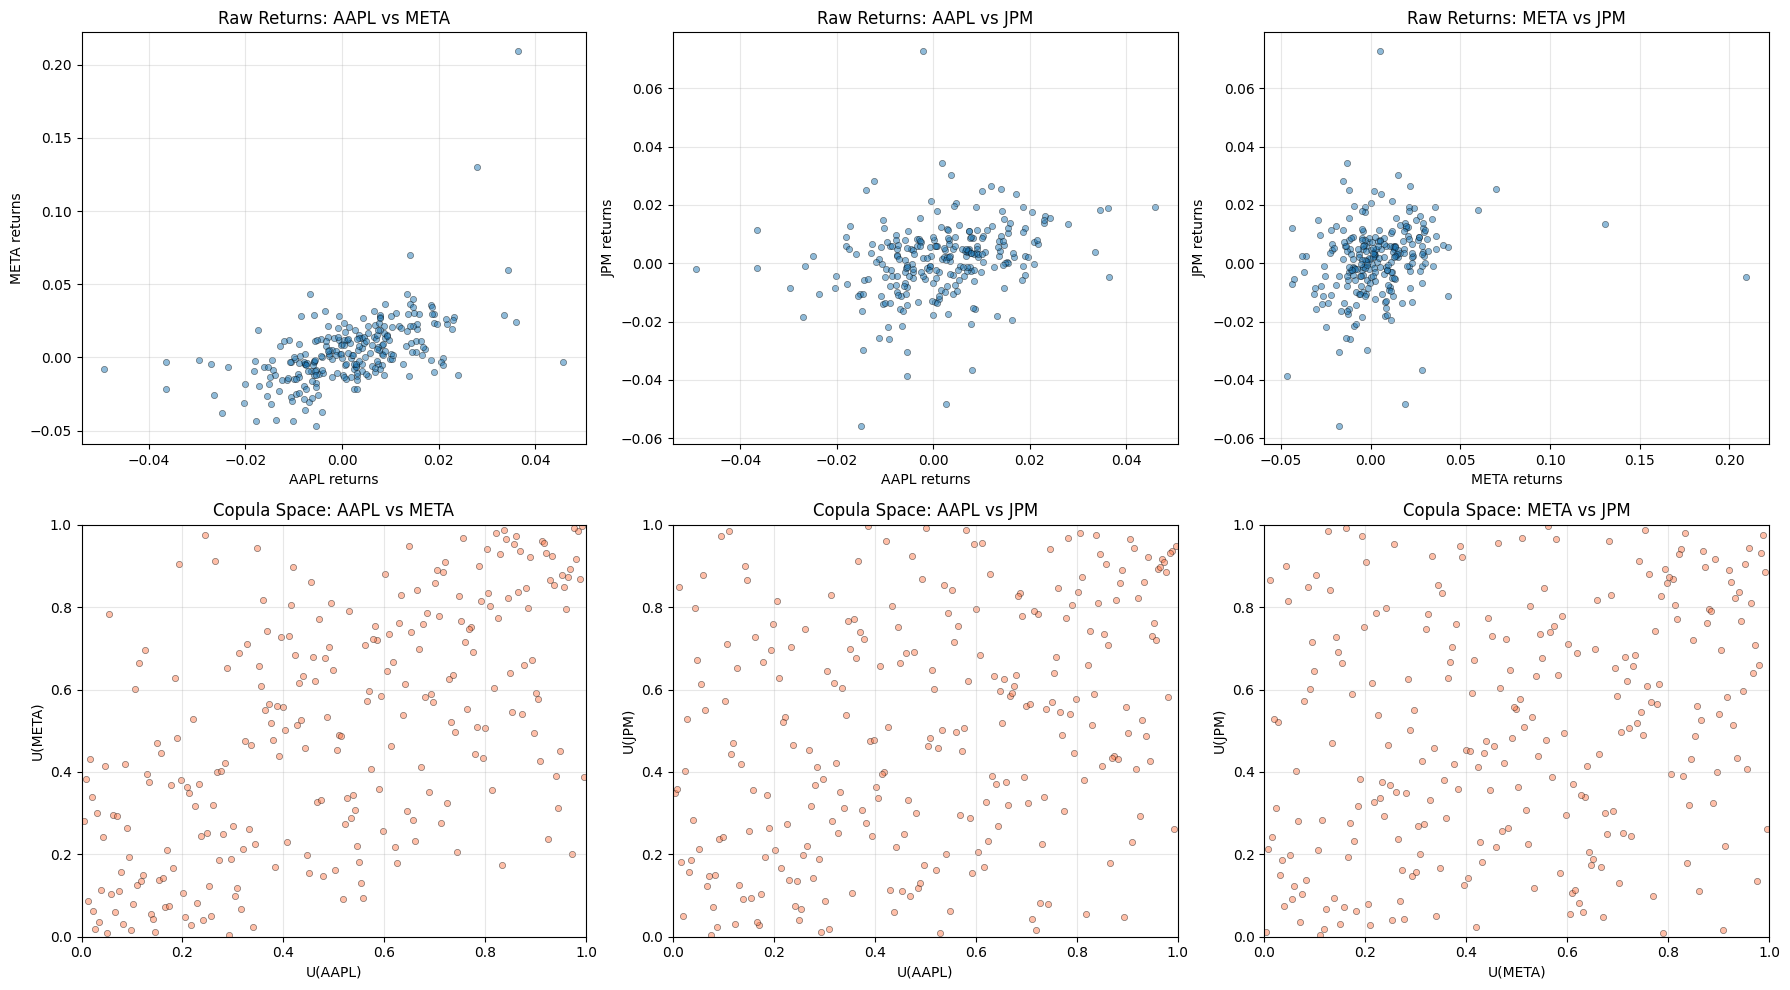

In [28]:
# Visualize dependence: raw returns space vs copula (pseudo-observations) space
pairs = list(combinations(TICKERS, 2))
n_pairs = len(pairs)

fig, axes = plt.subplots(2, n_pairs, figsize=(6*n_pairs, 10))

for j, (asset_i, asset_j) in enumerate(pairs):
    # Raw returns space
    ax_raw = axes[0, j]
    ax_raw.scatter(returns_window[asset_i], returns_window[asset_j], 
                   alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
    ax_raw.set_xlabel(f'{asset_i} returns')
    ax_raw.set_ylabel(f'{asset_j} returns')
    ax_raw.set_title(f'Raw Returns: {asset_i} vs {asset_j}')
    ax_raw.grid(True, alpha=0.3)
    
    # Copula space (pseudo-observations)
    ax_copula = axes[1, j]
    ax_copula.scatter(pseudo_obs[asset_i], pseudo_obs[asset_j], 
                      alpha=0.5, s=20, edgecolors='k', linewidths=0.5, color='coral')
    ax_copula.set_xlabel(f'U({asset_i})')
    ax_copula.set_ylabel(f'U({asset_j})')
    ax_copula.set_title(f'Copula Space: {asset_i} vs {asset_j}')
    ax_copula.set_xlim(0, 1)
    ax_copula.set_ylim(0, 1)
    ax_copula.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'raw_returns_vs_pseudo_obs.png'))
plt.show()

##### Interpretation of Raw Returns and Copula Space

**Raw returns**

The **AAPL–META** pair exhibits a clear upward-sloping cloud, indicating a positive dependence and frequent joint large moves. In contrast, **AAPL–JPM** and **META–JPM** show more diffuse scatter patterns, reflecting weaker dependence between tech firms and a bank. Across all pairs, extreme returns are more dispersed than expected under normality, suggesting heavy-tailed behavior and occasional simultaneous large shocks.

**Copula space**

In copula space, **AAPL–META** displays a marked diagonal structure, confirming a positive dependence. The clustering of observations near the corners (0,0) and (1,1) further reveals tail dependence—meaning that extreme moves tend to occur together. By comparison, **AAPL–JPM** and **META–JPM** resemble an almost uniform cloud over \([0,1]^2\), confirming weaker dependence and only marginal tail co-movement.

**Implications for copula choice**

Given the evident heavy tails and clear tail dependence in **AAPL–META**, a Gaussian copula, though adequate for symmetric dependence, cannot capture the probability mass in the joint extremes. The Student-t copula, however, explicitly models tail dependence and is therefore the appropriate copula for this portfolio. Its structure aligns with the empirical behavior of the assets, particularly the strong, tail-driven co-movements between the two tech stocks. Consequently, the Student-t copula provides a more realistic representation of joint downside risk than its Gaussian counterpart.

### b. Fit Gaussian and Student-t copulas

**Gaussian Copula:**
$$
C^\text{Gauss}(u_1, \ldots, u_d; \Sigma) = \Phi_\Sigma\big(\Phi^{-1}(u_1), \ldots, \Phi^{-1}(u_d)\big)
$$
where $\Phi_\Sigma$ is the multivariate normal CDF with correlation matrix $\Sigma$.

**Student-t Copula:**
$$
C^t(u_1, \ldots, u_d; \Sigma, \nu) = T_{\Sigma, \nu}\big(T_\nu^{-1}(u_1), \ldots, T_\nu^{-1}(u_d)\big)
$$
where $T_{\Sigma,\nu}$ is the multivariate Student-t CDF with correlation $\Sigma$ and degrees of freedom $\nu$.

In [29]:
# Fit Gaussian Copula
gauss_cop = copulae.elliptical.GaussianCopula(dim=len(TICKERS))
gauss_cop.fit(pseudo_obs.values, to_pobs=False)

gauss_corr = pd.DataFrame(gauss_cop.sigma, index=TICKERS, columns=TICKERS)
gauss_loglik = gauss_cop.log_lik(pseudo_obs.values, to_pobs=False)
gauss_num_params = len(gauss_cop.params)

print("GAUSSIAN COPULA\n")
print(gauss_corr.round(4))
print(f"\nLog-Likelihood: {gauss_loglik:.4f}")
print(f"Number of Parameters: {gauss_num_params}")

GAUSSIAN COPULA

        AAPL    META     JPM
AAPL  1.0000  0.2870  0.3428
META  0.2870  1.0000  0.5979
JPM   0.3428  0.5979  1.0000

Log-Likelihood: 69.2904
Number of Parameters: 3


In [30]:
d = len(TICKERS)

# Fit Student-t Copula
t_cop = copulae.StudentCopula(dim=d)
t_cop.fit(pseudo_obs.values, to_pobs=False)

print("STUDENT-T COPULA\n")

nu = t_cop.params[0]

print("Correlation Matrix sigma:")
corr_matrix = t_cop.sigma
print(pd.DataFrame(corr_matrix, index=TICKERS, columns=TICKERS).round(4))

t_loglik = t_cop.log_lik(pseudo_obs.values, to_pobs=False)
t_num_params = d * (d - 1) // 2 + 1

print(f"\nLog-Likelihood: {t_loglik:.4f}")
print(f"Number of Parameters: {t_num_params}")
print(f"Degrees of Freedom nu: {nu:.4f}")

STUDENT-T COPULA

Correlation Matrix sigma:
        AAPL    META     JPM
AAPL  1.0000  0.3021  0.3494
META  0.3021  1.0000  0.5995
JPM   0.3494  0.5995  1.0000

Log-Likelihood: 70.9956
Number of Parameters: 4
Degrees of Freedom nu: 13.0523


##### Explanation of the fitting procedure

We first transform the returns into **pseudo-observations**
$$
U_{t,i} = \frac{\text{rank}(R_{t,i})}{W+1}
$$
so each marginal is approximately uniform on \[0,1]\.

This allows us to fit the copulas **only on the dependence structure**.

Both copulas are then fitted using **maximum likelihood**: the pseudo-observations are transformed using the appropriate inverse CDF, and the log-likelihood is maximized over the copula parameters.

**Gaussian copula.**  
Maximizes the likelihood over the correlation matrix $\Sigma$ only, after applying the inverse normal CDF.

**Student-t copula.**  
Same procedure as the Gaussian copula, but with one additional parameter: the **degrees of freedom** $\nu$, which controls tail dependence.

Thus, both models share the same fitting framework. The Student-t copula simply includes an extra parameter to capture heavier joint tails.

### c. Simulate from copulas and compare with original returns

We simulate from the fitted copulas and map back to the original return scale using empirical marginals.

1. **Generate uniform samples (dependence only)**

   From the fitted copula $C_\theta$, we simulate
   $$
   U^{(t)} = (U^{(t)}_1, \dots, U^{(t)}_d) \sim C_\theta, \qquad t = 1,\dots,T,
   $$
   where $U^{(t)}_i \in (0,1)$.  
   These uniforms encode the **dependence structure** of the Gaussian or Student-t copula.

2. **Apply the inverse empirical CDFs (recover marginals)**

   For each asset $i$, let $\hat F_i^{-1}$ denote the empirical quantile function built from the observed returns.  
   Each uniform component is transformed via
   $$
   X^{(t)}_i = \hat F_i^{-1}\!\left(U^{(t)}_i\right),
   $$
   which ensures the simulated data have the **same marginal distribution** as the original returns.
   
3. **Construct simulated return series**

   Repeating this for all assets and all samples produces two synthetic datasets,
   $
   X^{(t)}_{\text{Gauss}}, \quad
   X^{(t)}_{\text{t-copula}}
   $
   each with the original empirical marginals but with dependence dictated by the fitted Gaussian or Student-t copula.

In [31]:
T = len(log_returns)
print(f"Simulating T={T} samples from each fitted copula...")

# Sample U ~ Copula
U_gauss = gauss_cop.random(T)
U_t = t_cop.random(T)

Simulating T=622 samples from each fitted copula...


In [32]:
def inverse_empirical(u, data):
    """
    Strict monotonic inverse-ECDF using interpolation
    Maps uniform U to real observed distribution of data.
    """
    data_sorted = np.sort(data)
    ranks = (np.arange(1, len(data_sorted) + 1)) / (len(data_sorted) + 1)
    return np.interp(u, ranks, data_sorted)

In [33]:
sim_gauss = pd.DataFrame({
    ticker: inverse_empirical(U_gauss[:, i], log_returns[ticker].values)
    for i, ticker in enumerate(TICKERS)
})
sim_t = pd.DataFrame({
    ticker: inverse_empirical(U_t[:, i], log_returns[ticker].values)
    for i, ticker in enumerate(TICKERS)
})

print("\nSimulated returns (Gaussian):")
display(sim_gauss.head())

print("\nSimulated returns (Student-t):")
display(sim_t.head())


Simulated returns (Gaussian):


,AAPL,META,JPM
0,0.006835,0.031292,0.010654
1,0.000621,0.039133,0.012063
2,0.023675,0.019501,0.004676
3,0.041175,0.029195,0.012324
4,0.006912,-0.003334,0.006475



Simulated returns (Student-t):


,AAPL,META,JPM
0,-0.000632,-0.001466,-0.021808
1,0.015395,0.001470,-0.007789
2,0.004492,-0.004676,-0.002281
3,-0.009489,-0.022141,-0.013369
4,-0.011390,0.001684,-0.043436


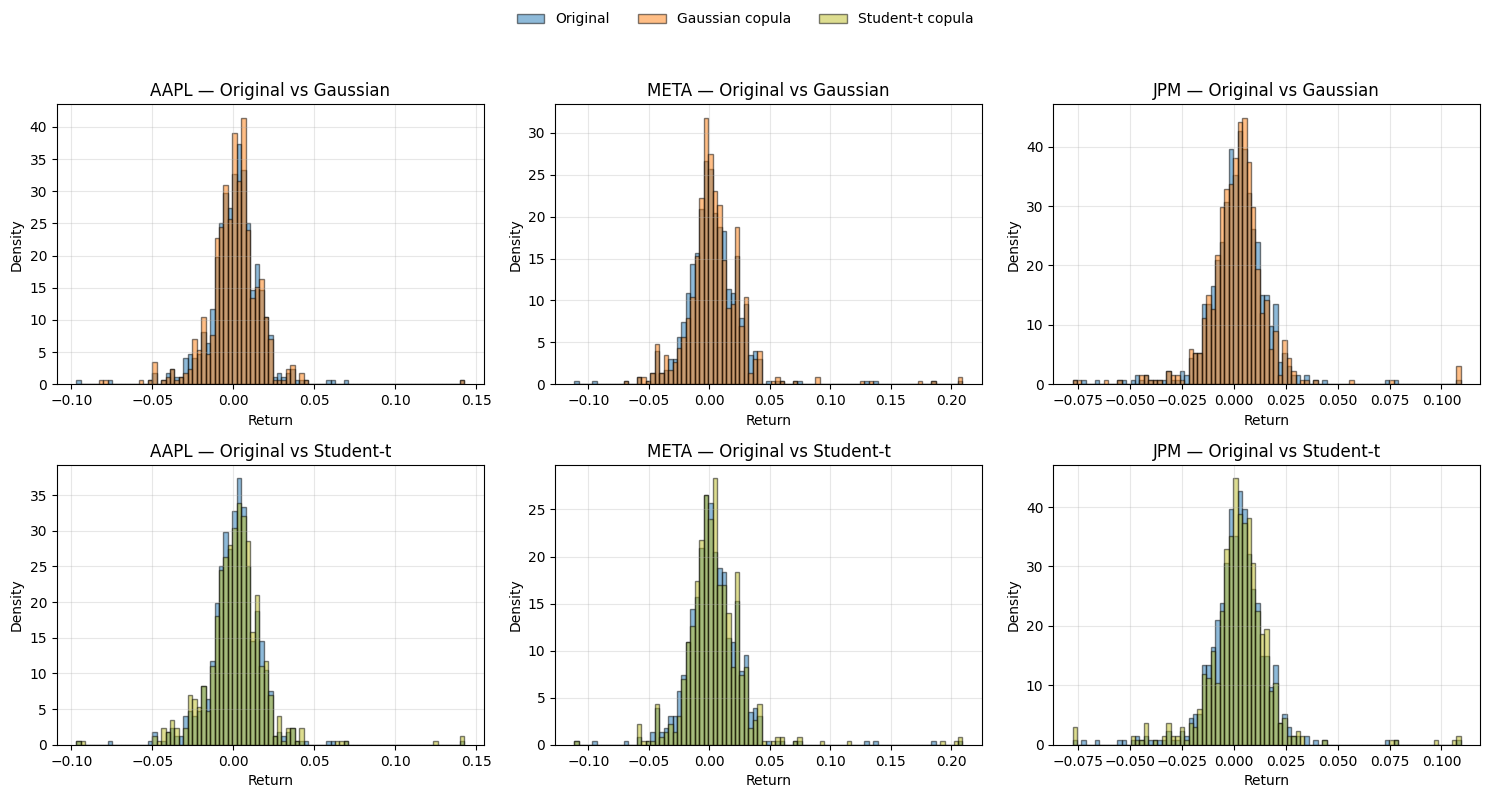

In [34]:
fig, axes = plt.subplots(
    2, len(TICKERS), figsize=(5 * len(TICKERS), 8), squeeze=False
)

for j, tk in enumerate(TICKERS):

    # Shared bins across original + both simulations
    pooled = np.concatenate([log_returns[tk], sim_gauss[tk], sim_t[tk]])
    bins = np.histogram_bin_edges(pooled, bins='auto')

    # ---- Row 1: Original vs Gaussian ----
    ax = axes[0, j]
    ax.hist(log_returns[tk], bins=bins, density=True, alpha=0.5,
            label="Original", edgecolor="k", color="tab:blue")
    ax.hist(sim_gauss[tk], bins=bins, density=True, alpha=0.5,
            label="Gaussian copula", edgecolor="k", color="tab:orange")
    ax.set_title(f"{tk} — Original vs Gaussian")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")
    ax.grid(True, alpha=0.3)

    # ---- Row 2: Original vs Student-t ----
    ax = axes[1, j]
    ax.hist(log_returns[tk], bins=bins, density=True, alpha=0.5,
            label="Original", edgecolor="k")
    ax.hist(sim_t[tk], bins=bins, density=True, alpha=0.5,
            label="Student-t copula", edgecolor="k", color="tab:olive")
    ax.set_title(f"{tk} — Original vs Student-t")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")
    ax.grid(True, alpha=0.3)

# Define legend patches manually
original_patch = mpatches.Patch(facecolor="tab:blue", alpha=0.5, label="Original", edgecolor="k")
gaussian_patch = mpatches.Patch(facecolor="tab:orange", alpha=0.5, label="Gaussian copula", edgecolor="k")
student_t_patch = mpatches.Patch(facecolor="tab:olive", alpha=0.5, label="Student-t copula", edgecolor="k")

fig.legend(
    handles=[original_patch, gaussian_patch, student_t_patch],
    loc="upper center", ncols=3, frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(os.path.join(OUT_DIR, 'copula_marginal_distributions_split.png'))
plt.show()

The histograms show that both simulated datasets closely match the original return distributions, as expected from using empirical quantile mapping.

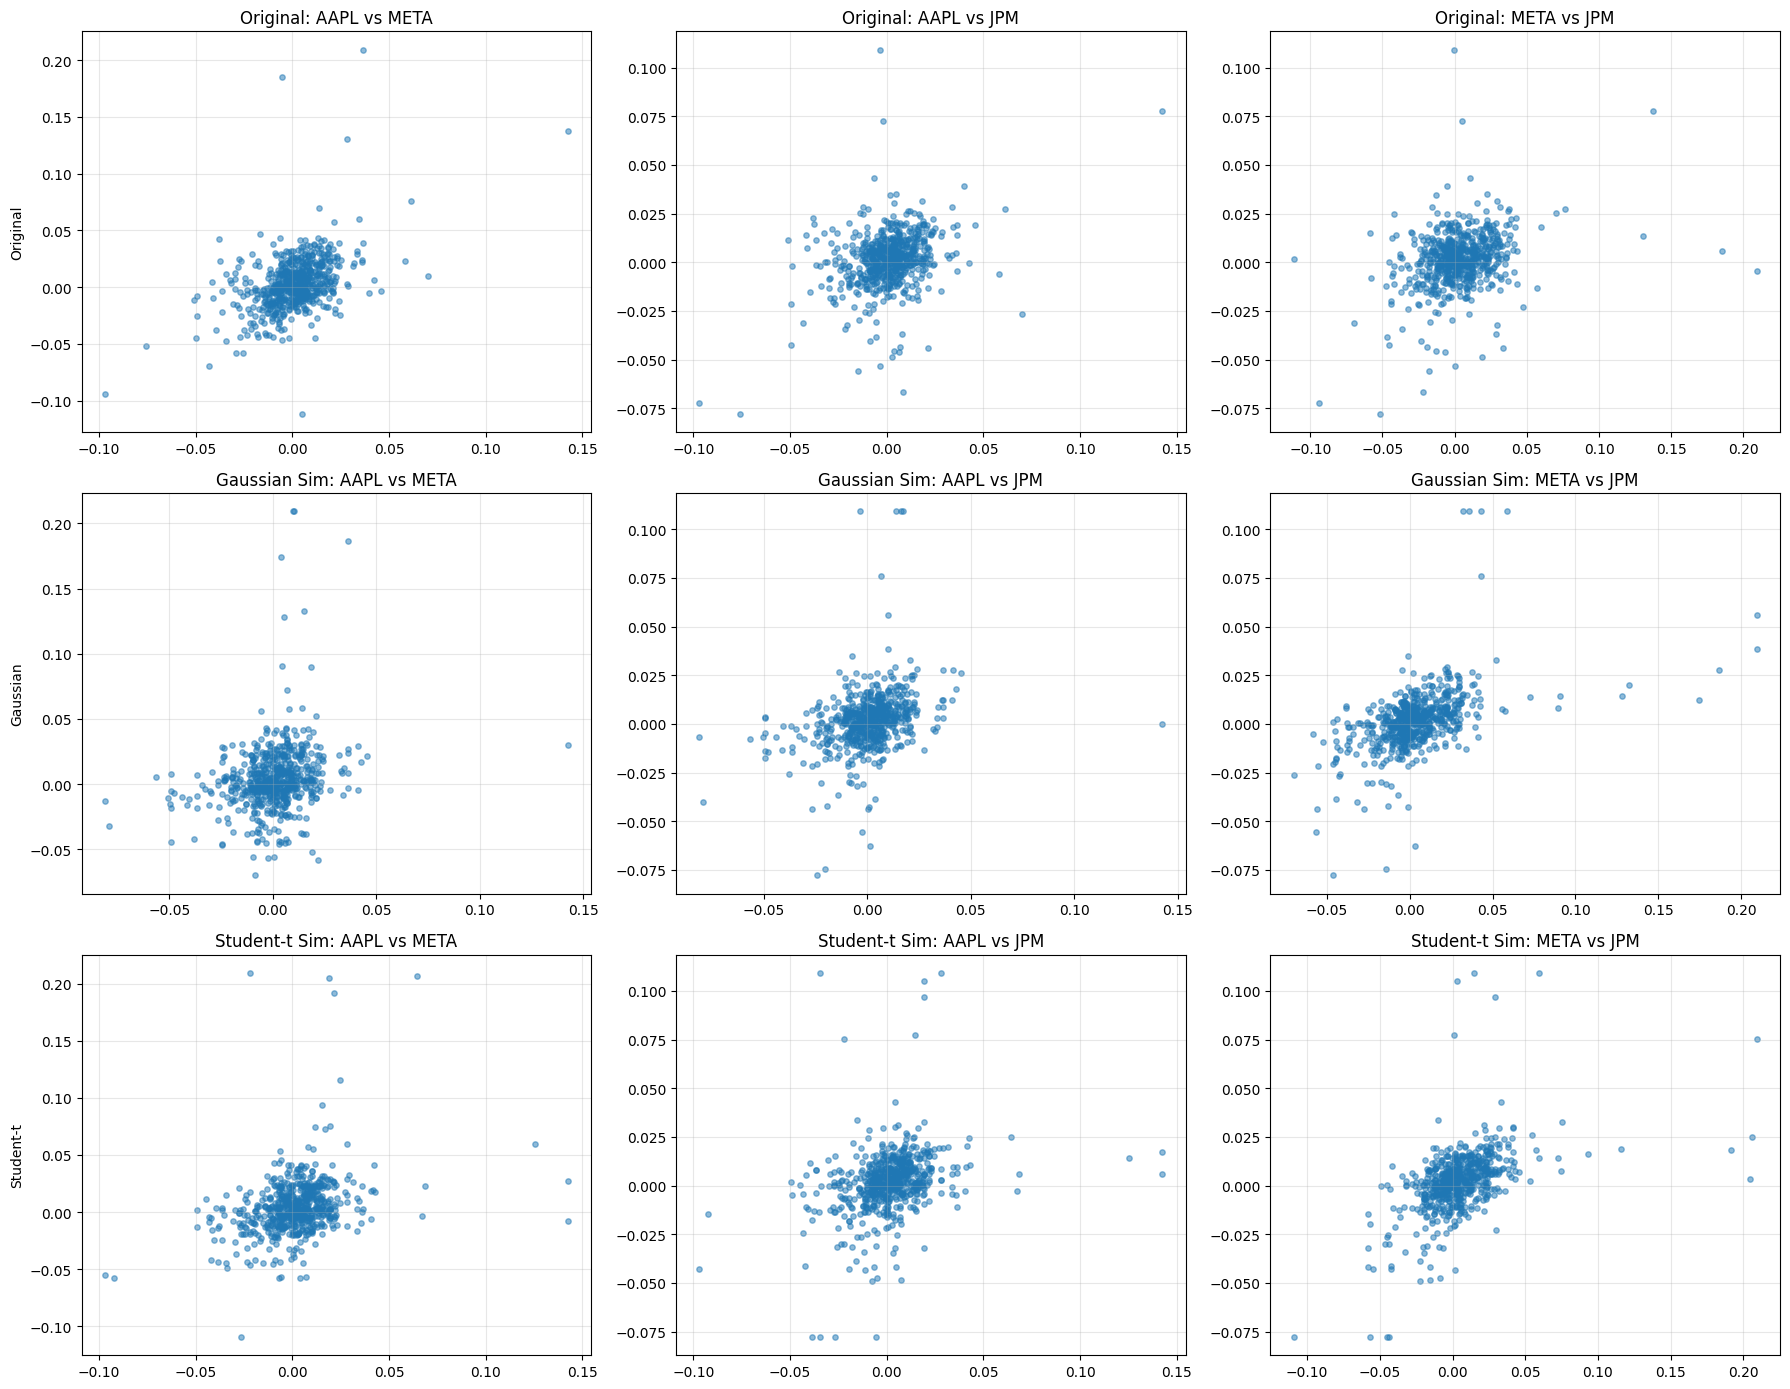

In [35]:
# Dependence structure
pairs = list(combinations(TICKERS, 2))
fig, axes = plt.subplots(3, len(pairs), figsize=(6 * len(pairs), 14), squeeze=False)

for col, (a, b) in enumerate(pairs):
    # 1) original
    ax = axes[0, col]
    ax.scatter(log_returns[a], log_returns[b], alpha=0.5, s=15)
    ax.set_title(f"Original: {a} vs {b}")
    ax.grid(True, alpha=0.3)

    # 2) Gaussian
    ax = axes[1, col]
    ax.scatter(sim_gauss[a], sim_gauss[b], alpha=0.5, s=15)
    ax.set_title(f"Gaussian Sim: {a} vs {b}")
    ax.grid(True, alpha=0.3)

    # 3) Student-t
    ax = axes[2, col]
    ax.scatter(sim_t[a], sim_t[b], alpha=0.5, s=15)
    ax.set_title(f"Student-t Sim: {a} vs {b}")
    ax.grid(True, alpha=0.3)

# annotate rows
axes[0,0].set_ylabel("Original")
axes[1,0].set_ylabel("Gaussian")
axes[2,0].set_ylabel("Student-t")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'copula_dependence_structure.png'))
plt.show()

The scatter plots indicate that both copulas reproduce the overall dependence structure. The Student-t copula generates slightly more joint extremes, but the differences remain modest given the estimated degrees of freedom.

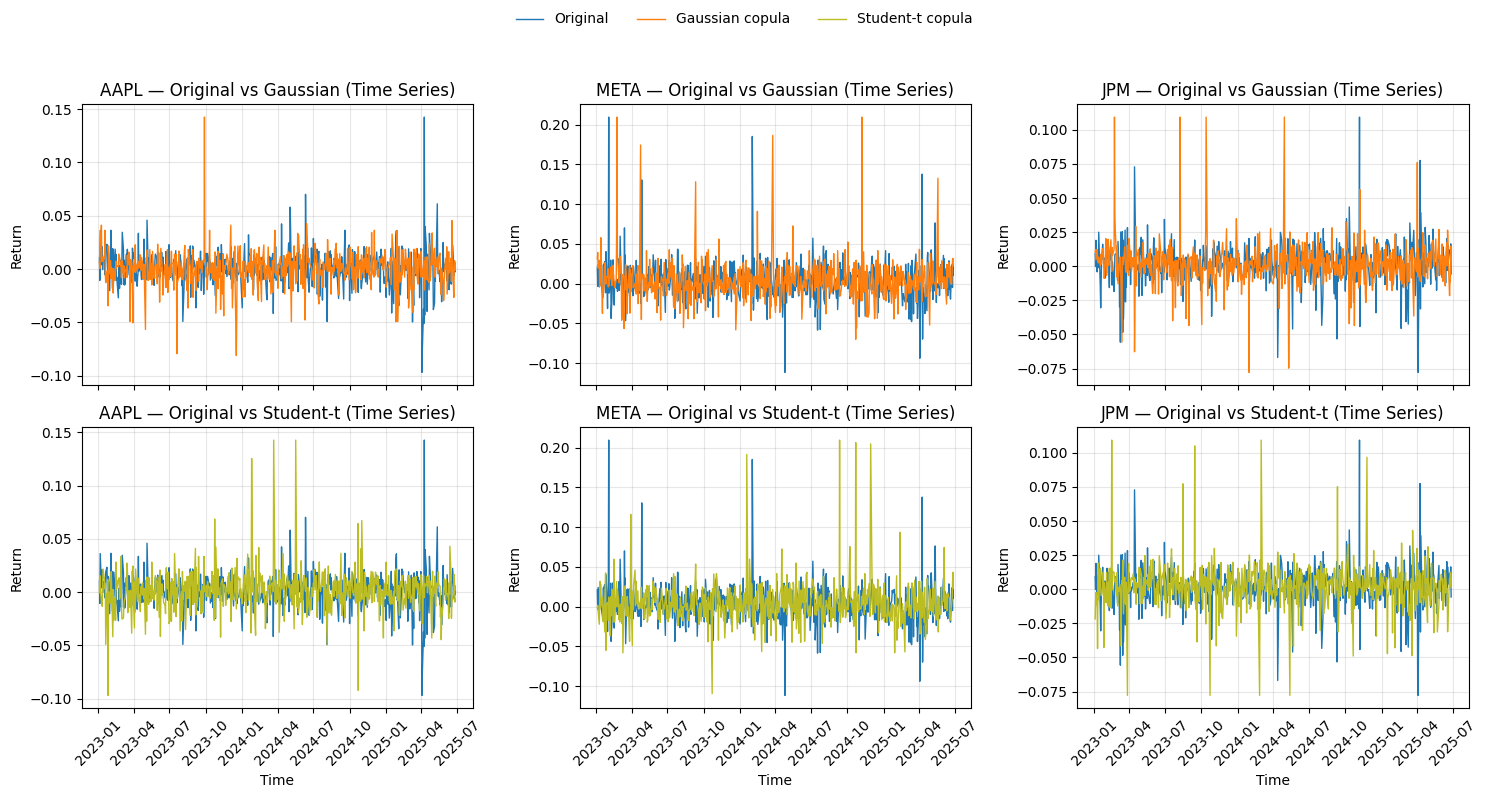

In [36]:
# Align simulated data index with original returns
sim_gauss.index = log_returns.index[:len(sim_gauss)]
sim_t.index     = log_returns.index[:len(sim_t)]

# Consistent colors with your histogram
COL_ORIG = "tab:blue"
COL_GAUS = "tab:orange"
COL_T    = "tab:olive"

fig, axes = plt.subplots(
    2, len(TICKERS), figsize=(5 * len(TICKERS), 8),
    squeeze=False, sharex='col'
)

for j, tk in enumerate(TICKERS):

    # ----- Row 1: Original vs Gaussian -----
    ax = axes[0, j]
    ax.plot(log_returns.index, log_returns[tk],
            lw=1, label="Original", color=COL_ORIG)
    ax.plot(sim_gauss.index, sim_gauss[tk],
            lw=1, label="Gaussian copula", color=COL_GAUS)
    ax.set_title(f"{tk} — Original vs Gaussian (Time Series)")
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)
    # no x-label on top row

    # ----- Row 2: Original vs Student-t -----
    ax = axes[1, j]
    ax.plot(log_returns.index, log_returns[tk],
            lw=1, label="Original", color=COL_ORIG)
    ax.plot(sim_t.index, sim_t[tk],
            lw=1, label="Student-t copula", color=COL_T)
    ax.set_title(f"{tk} — Original vs Student-t (Time Series)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis="x", rotation=45)  # nicer date labels

handles1, labels1 = axes[0, 0].get_legend_handles_labels()
handles2, labels2 = axes[1, 0].get_legend_handles_labels()

handles = list(handles1)
labels = list(labels1)
for h, lab in zip(handles2, labels2):
    if lab not in labels:
        handles.append(h)
        labels.append(lab)

fig.legend(handles, labels,
           loc="upper center", ncols=3, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(os.path.join(OUT_DIR, "copula_time_series_comparison.png"))
plt.show()

The plots above compare the original return series with returns simulated using Gaussian and Student-t copulas for AAPL, META, and JPM.

Key observations:

- **Overall return dynamics:** All series fluctuate around zero with frequent sign changes, consistent with daily stock return behavior.

- **Volatility clustering:** The **original data** exhibit periods where large movements are followed by other large movements (both positive and negative), particularly visible in META and AAPL around early 2024. Both copula simulations **partially replicate** this phenomenon, but the effect is **more pronounced in the Student-t copula**, where clusters of large returns appear more frequently, especially for META.

- **Gaussian copula behavior:** The Gaussian generated series tracks the general variability of the original returns but displays **smoother fluctuations**. Large spikes are **less frequent and less intense**, indicating that the Gaussian copula **underestimates tail events** and does not fully capture periods of heightened volatility.

- **Student-t copula behavior:** The Student-t simulated paths show **higher amplitude jumps and more erratic bursts**, aligning more closely with the original heavy-tailed structure. This copula better reproduces **extreme shocks and volatility clustering**, particularly visible in META and JPM, where large returns tend to appear in temporal clusters.

While both copulas mimic the central fluctuations of the return series, **the Student-t copula provides a more realistic replication of extreme events and volatility clustering**, making it more suitable for modeling financial return dynamics and risk.

## 5) Portfolio VaR/ES with copulas (rolling)

Equal-weighted portfolio of AAPL, MSFT, JPM. Compare univariate models (as in Exercise 3) vs copula-based VaR/ES with rolling windows.

At each time, fit copulas on last W weeks, simulate N scenarios, estimate VaR/ES from simulated portfolio returns, then backtest.

### a. Univariate models on portfolio returns

Apply the same backtesting procedure as in question 3, but now on equal-weighted portfolio returns.

In [37]:
# Compute equal-weighted portfolio returns
# Portfolio return = (1/3) * R_AAPL + (1/3) * R_META + (1/3) * R_JPM
weights = np.array([1/3, 1/3, 1/3])

portfolio_returns = (log_returns[TICKERS] * weights).sum(axis=1)

print("Equal-weighted portfolio returns:")
print(f"Shape: {portfolio_returns.shape}")
print(f"Mean: {portfolio_returns.mean():.6f}")
print(f"Std Dev: {portfolio_returns.std():.6f}")
print(f"Min: {portfolio_returns.min():.6f}")
print(f"Max: {portfolio_returns.max():.6f}")
print("\nFirst 5 portfolio returns:")
print(portfolio_returns.head())

Equal-weighted portfolio returns:
Shape: (622,)
Mean: 0.001652
Std Dev: 0.014184
Min: -0.087699
Max: 0.119242

First 5 portfolio returns:
Date
2023-01-04    0.013469
2023-01-05   -0.004755
2023-01-06    0.026354
2023-01-09   -0.001433
2023-01-10    0.013395
dtype: float64


In [38]:
# Apply rolling-window forecasts to portfolio returns (same as question 3)
print("Computing rolling VaR/ES for portfolio using univariate models...")
print(f"Window size: {WINDOW} days")
print(f"Confidence levels: {CONFIDENCE}")

METHODS = {
    "historical": historical_simulation,
    "gaussian": gaussian_normal_distribution,
    "student": student_var_es,
    "parametric": conditional_parametric_var_es,
    "fhs": filtered_historical_simulation
}

L_portfolio = -portfolio_returns
portfolio_rolling_results = rolling_forecast(L_portfolio, WINDOW, METHODS, CONFIDENCE)

print(f"\nRolling forecasts complete")
print(f"Results shape: {portfolio_rolling_results.shape}")
print(f"Number of forecasts: {len(portfolio_rolling_results.dropna())}")

Computing rolling VaR/ES for portfolio using univariate models...
Window size: 252 days
Confidence levels: [0.95, 0.99]

Rolling forecasts complete
Results shape: (371, 20)
Number of forecasts: 371


In [39]:
# Backtest portfolio VaR using Kupiec POF test
print("-"*60)
print("PORTFOLIO VaR BACKTESTING - CHRISTOFFERSEN CONDITIONAL COVERAGE TEST - KUPIEC POF TEST")
print("-"*60)

result = pd.DataFrame(columns = ['Confidence Level', 'Method', 'POF_p_value', 'Christoffersen_p_value'])
for confidence in CONFIDENCE:
    alpha = 1 - confidence
    print(f"\n{'-'*60}")
    print(f"Confidence Level: {int(confidence*100)}%")
    print(f"{'-'*60}\n")
    
    for method in METHODS.keys():
        VaR_portfolio = portfolio_rolling_results[method]['VaR'][confidence]
        print(f'\nPOF test for Portfolio - {method} method:')
        POF = kupiec_pof_test(VaR_portfolio, L_portfolio, alpha)
        LR_ind = christoffersen(VaR_portfolio, L_portfolio)
        result = pd.concat([
            result,
            pd.DataFrame([{
                'Confidence Level': f'{int(confidence*100)}%',
                'Method': method,
                'POF_p_value': chi_square_test(POF, df=1, method_name=f'Portfolio - {method}', test_name='POF test'),
                'Christoffersen_p_value': chi_square_test(LR_ind + POF, df=2, method_name=f'Portfolio - {method}', test_name='Christoffersen conditional coverage test')
            }])
        ], ignore_index=True)

------------------------------------------------------------
PORTFOLIO VaR BACKTESTING - CHRISTOFFERSEN CONDITIONAL COVERAGE TEST - KUPIEC POF TEST
------------------------------------------------------------

------------------------------------------------------------
Confidence Level: 95%
------------------------------------------------------------


POF test for Portfolio - historical method:
Performing POF test
The test statistic and p value for Portfolio - historical are : t_stat 2.139066522522881, p_value 0.14358924093531744
Fail to reject the null hypothesis at 5% significance level for Portfolio - historical.

Performing Christoffersen conditional coverage test
The test statistic and p value for Portfolio - historical are : t_stat 2.970737011636117, p_value 0.22641888862335358
Fail to reject the null hypothesis at 5% significance level for Portfolio - historical.


POF test for Portfolio - gaussian method:
Performing POF test
The test statistic and p value for Portfolio - gaus

In [40]:
print("-"*60)
print("PORTFOLIO VaR & ES BACKTESTING")
print("-"*60)

# Result table: add ES columns
result = pd.DataFrame(columns=[
    'Confidence Level',
    'Method',
    'POF_p_value',
    'Christoffersen_p_value',
    'ES_Z1_stat',
    'ES_p_value'
])

portfolio_loss = L_portfolio.sort_index()

for confidence in CONFIDENCE:
    alpha = 1 - confidence
    print(f"\n{'-'*60}")
    print(f"Confidence Level: {int(confidence*100)}%")
    print(f"{'-'*60}\n")
    
    for method in METHODS.keys():
        # -------- VaR backtests --------
        VaR_portfolio = portfolio_rolling_results[method]['VaR'][confidence]

        print(f'\nPOF & Christoffersen tests for Portfolio - {method} method:')
        POF = kupiec_pof_test(VaR_portfolio, L_portfolio, alpha)
        LR_ind = christoffersen(VaR_portfolio, L_portfolio)

        p_pof = chi_square_test(
            POF, df=1,
            method_name=f'Portfolio - {method}',
            test_name='POF test'
        )
        p_christoffersen = chi_square_test(
            LR_ind + POF, df=2,
            method_name=f'Portfolio - {method}',
            test_name='Christoffersen conditional coverage test'
        )

        # -------- ES backtest (Acerbi–Szekely Z1) --------
        ES_portfolio = portfolio_rolling_results[method]['ES'][confidence]

        Z1_simulated = monte_carlo_es_backtest_z1(
            VaR_series=VaR_portfolio,
            ES_series=ES_portfolio,
            Loss_series=portfolio_loss,
            sampler=sampler[method],
            window=WINDOW,
            M=1000
        )

        real_Z1 = es_backtest_z1(
            VaR_series=VaR_portfolio,
            ES_series=ES_portfolio,
            Loss_series=portfolio_loss
        )

        p_es = (Z1_simulated >= real_Z1).sum() / len(Z1_simulated)

        result = pd.concat([
            result,
            pd.DataFrame([{
                'Confidence Level': f'{int(confidence*100)}%',
                'Method': method,
                'POF_p_value': p_pof,
                'Christoffersen_p_value': p_christoffersen,
                'ES_Z1_stat': real_Z1,
                'ES_p_value': p_es
            }])
        ], ignore_index=True)

summary = result.set_index(['Confidence Level', 'Method'])[
    ['POF_p_value', 'Christoffersen_p_value', 'ES_Z1_stat', 'ES_p_value']
]

------------------------------------------------------------
PORTFOLIO VaR & ES BACKTESTING
------------------------------------------------------------

------------------------------------------------------------
Confidence Level: 95%
------------------------------------------------------------


POF & Christoffersen tests for Portfolio - historical method:
Performing POF test
The test statistic and p value for Portfolio - historical are : t_stat 2.139066522522881, p_value 0.14358924093531744
Fail to reject the null hypothesis at 5% significance level for Portfolio - historical.

Performing Christoffersen conditional coverage test
The test statistic and p value for Portfolio - historical are : t_stat 2.970737011636117, p_value 0.22641888862335358
Fail to reject the null hypothesis at 5% significance level for Portfolio - historical.


POF & Christoffersen tests for Portfolio - gaussian method:
Performing POF test
The test statistic and p value for Portfolio - gaussian are : t_stat 2.

In [41]:
summary

POF_p_value  Christoffersen_p_value  ES_Z1_stat  \
Confidence Level Method                                                        
95%              historical     0.143589                0.226419    0.164086   
                 gaussian       0.143589                0.226419    0.313611   
                 student        0.058689                0.132580    0.178460   
                 parametric     0.306073                0.306447    0.151297   
                 fhs            0.914956                0.657475    0.111985   
99%              historical     0.006671                0.014118    0.057640   
                 gaussian       0.000159                0.000630    0.267539   
                 student        0.002081                0.005603   -0.018868   
                 parametric     0.052340                0.128040    0.121492   
                 fhs            0.272715                0.497171    0.071448   

                             ES_p_value  
Confidence Level Method                  
95%              historical       0.015  
                 gaussian         0.000  
                 student          0.044  
                 parametric       0.005  
                 fhs              0.056  
99%              historical       0.210  
                 gaussian         0.007  
                 student          0.421  
                 parametric       0.052  
                 fhs              0.297

### b. Copula-based portfolio VaR/ES (rolling)

At each time $t$, fit the copulas as in 4.b) on the last $W$ days of portfolio component returns. Simulate $N = 1000$ returns from each fitted copula, then estimate VaR/ES from the simulated portfolio returns.

In [42]:
def copula_portfolio_var_es(returns_df, tickers, weights, W, N_sim=1000, confidence=CONFIDENCE):
    """
    Rolling copula-based VaR/ES estimation for portfolio.
    
    For each time t, fit Gaussian and Student-t copulas on the last W days of returns,
    simulate N_sim scenarios, construct portfolio returns, and compute VaR/ES.
    
    Parameters:
        returns_df : pd.DataFrame
            Log returns for all assets
        tickers : list
            List of ticker symbols
        weights : np.array
            Portfolio weights (should sum to 1)
        W : int
            Rolling window size
        N_sim : int
            Number of Monte Carlo simulations
        alphas : list
            Confidence levels
        
    Returns:
        results : dict
            Dictionary with 'gaussian' and 'student' keys, each containing VaR and ES forecasts
    """
    T = len(returns_df)
    
    # Initialize result storage
    results = {
        'gaussian': {
            'VaR': {a: pd.Series(index=returns_df.index[W:], dtype=float) for a in confidence},
            'ES': {a: pd.Series(index=returns_df.index[W:], dtype=float) for a in confidence}
        },
        'student': {
            'VaR': {a: pd.Series(index=returns_df.index[W:], dtype=float) for a in confidence},
            'ES': {a: pd.Series(index=returns_df.index[W:], dtype=float) for a in confidence}
        }
    }
    
    # Rolling window estimation
    for t in range(W, T):
        # Extract window data
        window_returns = returns_df.iloc[t-W:t][tickers].copy()
        pseudo_obs = compute_pseudo_obs(window_returns)
        
        # Fit Gaussian copula
        gauss_cop = copulae.elliptical.GaussianCopula(dim=len(tickers))
        gauss_cop.fit(pseudo_obs.values, to_pobs=False)
        
        # Fit Student-t copula
        t_cop = copulae.StudentCopula(dim=len(tickers))
        t_cop.fit(pseudo_obs.values, to_pobs=False)
        
        # Simulate from copulas
        U_gauss = gauss_cop.random(N_sim)
        U_t = t_cop.random(N_sim)
        
        # Convert copula samples to returns
        sim_returns_gauss = np.zeros((N_sim, len(tickers)))
        sim_returns_t = np.zeros((N_sim, len(tickers)))
        
        for i, ticker in enumerate(tickers):
            sim_returns_gauss[:, i] = inverse_empirical(U_gauss[:, i], window_returns[ticker].values)
            sim_returns_t[:, i] = inverse_empirical(U_t[:, i], window_returns[ticker].values)
        
        # Compute portfolio returns and losses
        portfolio_returns_gauss = sim_returns_gauss @ weights
        portfolio_returns_t = sim_returns_t @ weights
        
        portfolio_losses_gauss = -portfolio_returns_gauss
        portfolio_losses_t = -portfolio_returns_t
        
        # Compute VaR and ES for each confidence level
        current_date = returns_df.index[t]
        
        for a in confidence:
            # Gaussian copula
            VaR_gauss = np.percentile(portfolio_losses_gauss, a * 100)
            ES_gauss = portfolio_losses_gauss[portfolio_losses_gauss >= VaR_gauss].mean()
            results['gaussian']['VaR'][a].loc[current_date] = VaR_gauss
            results['gaussian']['ES'][a].loc[current_date] = ES_gauss
            
            # Student-t copula
            VaR_t = np.percentile(portfolio_losses_t, a * 100)
            ES_t = portfolio_losses_t[portfolio_losses_t >= VaR_t].mean()
            results['student']['VaR'][a].loc[current_date] = VaR_t
            results['student']['ES'][a].loc[current_date] = ES_t
    
    return results

In [43]:
def copula_sampler(L_window, M, type='gaussian'):
    """
    L_window: DataFrame or 2D array of shape (T_window, d)
              rows = time, columns = assets (returns)
    M: number of simulated scenarios
    type: 'gaussian' or 'student'
    """
    L_window = pd.DataFrame(L_window)
    d = L_window.shape[1]

    # Pseudo-observations 
    U = compute_pseudo_obs(L_window)  

    if type == 'gaussian':
        cop = copulae.elliptical.GaussianCopula(dim=d)
    else:
        cop = copulae.StudentCopula(dim=d)

    cop.fit(U.values, to_pobs=False)

    # Simulate U
    U_sim = cop.random(M) 

    # Map each marginal back 
    sim_returns = np.zeros((M, d))
    for i in range(d):
        sim_returns[:, i] = inverse_empirical(U_sim[:, i], L_window.iloc[:, i].values)

    # Compute portfolio returns and losses
    portfolio_returns = sim_returns @ weights
    portfolio_losses = -portfolio_returns

    return portfolio_losses 

In [44]:
def monte_carlo_es_backtest_z1_copula(VaR_series, ES_series, portfolio_loss, asset_returns, window, copula_type, M=1000):
    """
    VaR_series, ES_series: rolling forecasts (aligned with portfolio_loss)
    portfolio_loss: Series of portfolio losses (same index as VaR/ES)
    asset_returns: DataFrame of asset returns (same index as portfolio_loss)
    window: rolling window length used to estimate VaR/ES
    copula_type: 'gaussian' or 'student'
    M: number of Monte Carlo paths
    """
    x = np.asarray(portfolio_loss, dtype=float)
    n = len(x)

    T = n - window + 1
    idx = portfolio_loss.index[window-1:]

    sims = np.empty((M, T), dtype=float)

    for t in range(T):
        # Window of asset returns used for estimation at time t
        L_window = asset_returns.iloc[t:t+window, :]
        draws = copula_sampler(L_window, M, type=copula_type)
        sims[:, t] = draws

    VaR = VaR_series.loc[idx]
    ES = ES_series.loc[idx]

    Z1 = np.empty(M, dtype=float)
    for m in range(M):
        sim_series = pd.Series(sims[m], index=idx)
        Z1[m] = es_backtest_z1(VaR, ES, sim_series)

    return Z1

In [45]:
def monte_carlo_es_backtest_z1_copula(
    VaR_series,
    ES_series,
    portfolio_loss,
    asset_returns,
    window,
    copula_type,
    M=1000
):
    """
    VaR_series, ES_series : pandas.Series
        Out-of-sample VaR/ES forecasts, same index (e.g. from rolling_forecast).
    portfolio_loss : pandas.Series
        Full portfolio loss series (in-sample + out-of-sample), NOT truncated.
    asset_returns : pandas.DataFrame
        Asset returns used to build the copula, same (or superset) index as portfolio_loss.
    window : int
        Rolling window length used to estimate VaR/ES and the copula.
    copula_type : str
        'gaussian' or 'student' (or any type supported by copula_sampler).
    M : int
        Number of Monte Carlo paths.

    Returns
    -------
    Z1 : np.ndarray of shape (M,)
        Monte Carlo distribution of the ES backtest statistic Z1.
    """

    # 1) Align and sort VaR/ES
    VaR = VaR_series.sort_index()
    ES  = ES_series.reindex(VaR.index)  # ensure same index/order as VaR

    # 2) Sort portfolio losses and asset returns
    portfolio_loss = portfolio_loss.sort_index()
    asset_returns  = asset_returns.sort_index()

    loss_index = portfolio_loss.index
    ret_index  = asset_returns.index

    # Out-of-sample dates (where VaR/ES are defined)
    idx = VaR.index
    T = len(idx)

    sims = np.empty((M, T), dtype=float)

    # 3) For each OOS date, reconstruct the window used to estimate VaR/ES & copula
    for j, date in enumerate(idx):
        # Position of this date in the full series
        loc_ret  = ret_index.get_loc(date)

        # Window of length `window` ending at `date`
        # (assumes VaR/ES start only after at least `window` observations)
        L_window = asset_returns.iloc[loc_ret - window + 1 : loc_ret + 1, :]

        # Draw portfolio losses from the copula-based sampler
        draws = copula_sampler(L_window, M, type=copula_type)
        draws = np.asarray(draws, dtype=float).reshape(M,)  # safety reshape
        sims[:, j] = draws

    # 4) Compute Z1 for each simulated path
    Z1 = np.empty(M, dtype=float)
    for m in range(M):
        sim_series = pd.Series(sims[m], index=idx)
        Z1[m] = es_backtest_z1(VaR, ES, sim_series)

    return Z1

In [46]:
# Compute copula-based rolling VaR/ES for portfolio
print("Computing copula-based rolling VaR/ES for portfolio...")
print(f"Window size: {WINDOW} days")
print(f"Monte Carlo simulations: N=1000")
print(f"Confidence levels: {CONFIDENCE}")
print(f"Portfolio weights: {weights}")

copula_results = copula_portfolio_var_es(
    returns_df=log_returns,
    tickers=TICKERS,
    weights=weights,
    W=WINDOW,
    N_sim=1000,
    confidence=CONFIDENCE
)

print(f"\nCopula-based rolling forecasts complete")
print(f"Number of Gaussian VaR forecasts (alpha=0.05): {copula_results['gaussian']['VaR'][0.95].notna().sum()}")
print(f"Number of Student-t VaR forecasts(alpha=0.05): {copula_results['student']['VaR'][0.95].notna().sum()}\n\n")

Computing copula-based rolling VaR/ES for portfolio...
Window size: 252 days
Monte Carlo simulations: N=1000
Confidence levels: [0.95, 0.99]
Portfolio weights: [0.33333333 0.33333333 0.33333333]

Copula-based rolling forecasts complete
Number of Gaussian VaR forecasts (alpha=0.05): 370
Number of Student-t VaR forecasts(alpha=0.05): 370




### c. Backtesting and comparison: univariate vs copula-based approaches

Compare portfolio VaR/ES backtests across univariate methods (part a) and copula-based approaches (part b). Assess whether explicit dependence modeling improves accuracy, especially in the tails.

In [47]:
# Backtest copula-based VaR using Kupiec POF test
print("-"*60)
print("COPULA-BASED PORTFOLIO VaR BACKTESTING - KUPIEC POF TEST")
print("-"*60)

result = pd.DataFrame(columns = ['Confidence Level', 'Method', 'POF_p_value'])
for confidence in CONFIDENCE:
    alpha = 1 - confidence
    print(f"\n{'-'*60}")
    print(f"Confidence Level: {int(confidence*100)}%")
    print(f"{'-'*60}\n")
    
    # Gaussian copula
    VaR_gauss = copula_results['gaussian']['VaR'][confidence]
    POF_gauss = kupiec_pof_test(VaR_gauss, L_portfolio, alpha)
    chi_square_test(POF_gauss, df=1, method_name='Portfolio - Gaussian Copula', test_name='POF test')
    
    # Student-t copula
    VaR_t = copula_results['student']['VaR'][confidence]
    POF_t = kupiec_pof_test(VaR_t, L_portfolio, alpha)
    chi_square_test(POF_t, df=1, method_name='Portfolio - Student-t Copula', test_name='POF test')

------------------------------------------------------------
COPULA-BASED PORTFOLIO VaR BACKTESTING - KUPIEC POF TEST
------------------------------------------------------------

------------------------------------------------------------
Confidence Level: 95%
------------------------------------------------------------

Performing POF test
The test statistic and p value for Portfolio - Gaussian Copula are : t_stat 2.858120841137544, p_value 0.09091364967136528
Fail to reject the null hypothesis at 5% significance level for Portfolio - Gaussian Copula.

Performing POF test
The test statistic and p value for Portfolio - Student-t Copula are : t_stat 2.176201627837813, p_value 0.14016000327258293
Fail to reject the null hypothesis at 5% significance level for Portfolio - Student-t Copula.


------------------------------------------------------------
Confidence Level: 99%
------------------------------------------------------------

Performing POF test
The test statistic and p value fo

In [48]:
# Backtest copula-based VaR using Christoffersen independence test
print("-"*60)
print("COPULA-BASED PORTFOLIO VaR BACKTESTING - CHRISTOFFERSEN CONDITIONAL COVERAGE TEST")
print("-"*60)

for confidence in CONFIDENCE:
    alpha = 1 - confidence
    print(f"\n{'-'*60}")
    print(f"Confidence Level: {int(confidence*100)}%")
    print(f"{'-'*60}\n")
    
    # Gaussian copula
    VaR_gauss = copula_results['gaussian']['VaR'][confidence]
    POF_gauss = kupiec_pof_test(VaR_gauss, L_portfolio, alpha)
    LR_ind_gauss = christoffersen(VaR_gauss, L_portfolio)
    chi_square_test(LR_ind_gauss + POF_gauss, df=2, method_name='Portfolio - Gaussian Copula', test_name='Christoffersen conditional coverage test')
    
    # Student-t copula
    VaR_t = copula_results['student']['VaR'][confidence]
    POF_t = kupiec_pof_test(VaR_t, L_portfolio, alpha)
    LR_ind_t = christoffersen(VaR_t, L_portfolio)
    chi_square_test(LR_ind_t + POF_t, df=2, method_name='Portfolio - Student-t Copula', test_name='Christoffersen conditional coverage test')

------------------------------------------------------------
COPULA-BASED PORTFOLIO VaR BACKTESTING - CHRISTOFFERSEN CONDITIONAL COVERAGE TEST
------------------------------------------------------------

------------------------------------------------------------
Confidence Level: 95%
------------------------------------------------------------

Performing Christoffersen conditional coverage test
The test statistic and p value for Portfolio - Gaussian Copula are : t_stat 3.486688042683478, p_value 0.17493443693499588
Fail to reject the null hypothesis at 5% significance level for Portfolio - Gaussian Copula.

Performing Christoffersen conditional coverage test
The test statistic and p value for Portfolio - Student-t Copula are : t_stat 3.00074418576169, p_value 0.22304715044895362
Fail to reject the null hypothesis at 5% significance level for Portfolio - Student-t Copula.


------------------------------------------------------------
Confidence Level: 99%
---------------------------

In [49]:
print("-"*60)
print("COPULA-BASED PORTFOLIO ES BACKTESTING (Acerbi-Szekely Z1 Test)")
print("-"*60)

asset_returns = log_returns[TICKERS]         # full asset returns
portfolio_loss = L_portfolio    # align with rolling VaR/ES

for confidence in CONFIDENCE:
    alpha = 1 - confidence
    print(f"\n{'-'*60}")
    print(f"Confidence Level: {int(confidence*100)}%")
    print(f"{'-'*60}\n")

    # Align VaR/ES first
    VaR_gauss = copula_results['gaussian']['VaR'][confidence]
    ES_gauss  = copula_results['gaussian']['ES'][confidence]

    # Gaussian copula ES backtest
    Z_1_sim_gauss = monte_carlo_es_backtest_z1_copula(
        VaR_gauss, ES_gauss, portfolio_loss, asset_returns, window=WINDOW,
        copula_type='gaussian', M=1000
    )
    real_Z1_gauss = es_backtest_z1(VaR_gauss, ES_gauss, portfolio_loss)
    p_gauss = (np.sum(Z_1_sim_gauss >= real_Z1_gauss) + 1) / (len(Z_1_sim_gauss) + 1)

    print(f"The test statistic and p value for Portfolio - Gaussian Copula are : "
          f"Z1_stat {real_Z1_gauss}, p_value {p_gauss}")
    if p_gauss < 0.05:
        print("Reject the null hypothesis at 5% significance level for Portfolio - Gaussian Copula.\n")
    else:
        print("Fail to reject the null hypothesis at 5% significance level for Portfolio - Gaussian Copula.\n")

    # Student-t copula ES backtest
    VaR_student = copula_results['student']['VaR'][confidence]
    ES_student  = copula_results['student']['ES'][confidence]

    Z_1_sim_student = monte_carlo_es_backtest_z1_copula(
        VaR_student, ES_student, portfolio_loss, asset_returns, window=WINDOW,
        copula_type='student', M=1000
    )
    real_Z1_student = es_backtest_z1(VaR_student, ES_student, portfolio_loss)
    p_student = (np.sum(Z_1_sim_student >= real_Z1_student) + 1) / (len(Z_1_sim_student) + 1)

    print(f"The test statistic and p value for Portfolio - Student Copula are : "
          f"Z1_stat {real_Z1_student}, p_value {p_student}")
    if p_student < 0.05:
        print("Reject the null hypothesis at 5% significance level for Portfolio - Student Copula.\n")
    else:
        print("Fail to reject the null hypothesis at 5% significance level for Portfolio - Student Copula.\n")

------------------------------------------------------------
COPULA-BASED PORTFOLIO ES BACKTESTING (Acerbi-Szekely Z1 Test)
------------------------------------------------------------

------------------------------------------------------------
Confidence Level: 95%
------------------------------------------------------------

The test statistic and p value for Portfolio - Gaussian Copula are : Z1_stat 0.15605758614900855, p_value 0.03396603396603397
Reject the null hypothesis at 5% significance level for Portfolio - Gaussian Copula.

The test statistic and p value for Portfolio - Student Copula are : Z1_stat 0.1597313039663668, p_value 0.056943056943056944
Fail to reject the null hypothesis at 5% significance level for Portfolio - Student Copula.


------------------------------------------------------------
Confidence Level: 99%
------------------------------------------------------------

The test statistic and p value for Portfolio - Gaussian Copula are : Z1_stat 0.16838078035757

In [50]:
def compute_backtest_statistics(VaR_forecasts,
                                ES_forecasts,
                                actual_losses,
                                alpha,
                                sampler_fn,
                                window,
                                M=1000):
    """
    Compute VaR and ES backtest statistics for a given method.
    """

    # ---------- VaR-based statistics ----------
    valid_idx = VaR_forecasts.notna() & actual_losses.notna()
    VaR_clean = VaR_forecasts[valid_idx]
    L_clean   = actual_losses[valid_idx]

    violations = (L_clean > VaR_clean).astype(int)
    n_violations = violations.sum()
    n_total = len(violations)
    violation_rate = n_violations / n_total if n_total > 0 else np.nan
    expected_violations = alpha * n_total

    # Kupiec POF
    POF = kupiec_pof_test(VaR_clean, L_clean, alpha)

    # Christoffersen independence component
    LR_ind = christoffersen(VaR_clean, L_clean)

    # ---------- NEW: p-values ----------
    POF_p_value = chi_square_test(
        POF, df=1,
        method_name='Portfolio',
        test_name='POF test'
    )

    Christoffersen_p_value = chi_square_test(
        LR_ind + POF, df=2,
        method_name='Portfolio',
        test_name='Christoffersen test'
    )

    # ---------- ES-based statistics ----------
    Z1_simulated = monte_carlo_es_backtest_z1(
        VaR_forecasts, ES_forecasts, actual_losses,
        sampler_fn, window=window, M=M
    )
    Z1_real = es_backtest_z1(VaR_forecasts, ES_forecasts, actual_losses)
    Z1_p_value = (Z1_simulated >= Z1_real).sum() / len(Z1_simulated)

    return {
        "n_violations": n_violations,
        "n_total": n_total,
        "violation_rate": violation_rate,
        "expected_rate": alpha,
        "expected_violations": expected_violations,
        "POF_statistic": POF,
        "POF_p_value": POF_p_value,                         # NEW
        "Christoffersen_statistic": LR_ind + POF,
        "Christoffersen_p_value": Christoffersen_p_value,   # NEW
        "Z1_stat": Z1_real,
        "Z1_p_value": Z1_p_value,
    }


In [57]:
print("-"*60)
print("COMPREHENSIVE COMPARISON: UNIVARIATE vs COPULA-BASED APPROACHES")
print("-"*60)

comparison_results = []

# Full asset returns and portfolio loss (for copula ES MC)
asset_returns = log_returns[TICKERS]
portfolio_loss = L_portfolio.sort_index()

# Choose a sampler for the VaR null for copulas (only used inside compute_backtest_statistics for ES,
# but we will override ES, so this can be anything reasonable, e.g. historical)
sampler_for_VaR = sampler['historical']

for confidence in CONFIDENCE:
    alpha = 1 - confidence

    # ---------- Univariate methods ----------
    for method in METHODS:
        VaR_forecast = portfolio_rolling_results[method]['VaR'][confidence]
        ES_forecast  = portfolio_rolling_results[method]['ES'][confidence]

        stats = compute_backtest_statistics(
            VaR_forecast,
            ES_forecast,
            portfolio_loss,
            alpha,
            sampler_fn=sampler[method],
            window=WINDOW,
            M=1000
        )

        comparison_results.append({
            "Confidence": f"{int(confidence*100)}%",
            "Approach": "Univariate",
            "Method": method,
            "Violations": stats["n_violations"],
            "Total": stats["n_total"],
            "Violation Rate": f"{stats['violation_rate']:.4f}",
            "Expected Rate": f"{stats['expected_rate']:.4f}",
            "POF Stat": f"{stats['POF_statistic']:.4f}",
            "POF p-value": f"{stats['POF_p_value']:.4f}",
            "Christoffersen Stat": f"{stats['Christoffersen_statistic']:.4f}",
            "Christoffersen p-value": f"{stats['Christoffersen_p_value']:.4f}",
            "Z1 Stat": f"{stats['Z1_stat']:.4f}",
            "Z1 p-value": f"{stats['Z1_p_value']:.4f}",
        })

    # ---------- Copula-based methods ----------
    for copula_type in ["gaussian", "student"]:
        VaR_forecast = copula_results[copula_type]['VaR'][confidence]
        ES_forecast  = copula_results[copula_type]['ES'][confidence]

        # 1) VaR-based statistics from the generic function
        stats = compute_backtest_statistics(
            VaR_forecast,
            ES_forecast,
            portfolio_loss,
            alpha,
            sampler_fn=sampler_for_VaR,   # only used for ES in generic MC, but we'll override ES
            window=WINDOW,
            M=1000
        )

        # 2) Override ES statistics using copula-based Monte Carlo
        Z1_sim = monte_carlo_es_backtest_z1_copula(
            VaR_forecast,
            ES_forecast,
            portfolio_loss,
            asset_returns,
            window=WINDOW,
            copula_type=copula_type,
            M=1000
        )
        Z1_real = es_backtest_z1(VaR_forecast, ES_forecast, portfolio_loss)
        Z1_p_value = (Z1_sim >= Z1_real).sum() / len(Z1_sim)

        stats["Z1_stat"] = Z1_real
        stats["Z1_p_value"] = Z1_p_value

        copula_name = "Gaussian Copula" if copula_type == "gaussian" else "Student-t Copula"

        comparison_results.append({
            "Confidence": f"{int(confidence*100)}%",
            "Approach": "Copula",
            "Method": copula_name,
            "Violations": stats["n_violations"],
            "Total": stats["n_total"],
            "Violation Rate": f"{stats['violation_rate']:.4f}",
            "Expected Rate": f"{stats['expected_rate']:.4f}",
            "POF Stat": f"{stats['POF_statistic']:.4f}",
            "POF p-value": f"{stats['POF_p_value']:.4f}",
            "Christoffersen Stat": f"{stats['Christoffersen_statistic']:.4f}",
            "Christoffersen p-value": f"{stats['Christoffersen_p_value']:.4f}",
            "Z1 Stat": f"{stats['Z1_stat']:.4f}",
            "Z1 p-value": f"{stats['Z1_p_value']:.4f}",
        })


# Create DataFrame for better visualization
comparison_df = pd.DataFrame(comparison_results)

print("\nSUMMARY TABLE:")
display(comparison_df)

# Save to CSV
comparison_df.to_csv(OUT_DIR / 'portfolio_var_es_comparison.csv', index=False)
print(f"\nComparison table saved to {OUT_DIR / 'portfolio_var_es_comparison.csv'}")

------------------------------------------------------------
COMPREHENSIVE COMPARISON: UNIVARIATE vs COPULA-BASED APPROACHES
------------------------------------------------------------
Performing POF test
The test statistic and p value for Portfolio are : t_stat 2.139066522522881, p_value 0.14358924093531744
Fail to reject the null hypothesis at 5% significance level for Portfolio.

Performing Christoffersen test
The test statistic and p value for Portfolio are : t_stat 2.970737011636117, p_value 0.22641888862335358
Fail to reject the null hypothesis at 5% significance level for Portfolio.

Performing POF test
The test statistic and p value for Portfolio are : t_stat 2.139066522522881, p_value 0.14358924093531744
Fail to reject the null hypothesis at 5% significance level for Portfolio.

Performing Christoffersen test
The test statistic and p value for Portfolio are : t_stat 2.970737011636117, p_value 0.22641888862335358
Fail to reject the null hypothesis at 5% significance level for 

,Confidence,Approach,Method,Violations,Total,Violation Rate,Expected Rate,POF Stat,POF p-value,Christoffersen Stat,Christoffersen p-value,Z1 Stat,Z1 p-value
0,95%,Univariate,historical,25,371,0.0674,0.0500,2.1391,0.1436,2.9707,0.2264,0.1641,0.0130
1,95%,Univariate,gaussian,25,371,0.0674,0.0500,2.1391,0.1436,2.9707,0.2264,0.3136,0.0000
2,95%,Univariate,student,27,371,0.0728,0.0500,3.5740,0.0587,4.0411,0.1326,0.1785,0.0600
3,95%,Univariate,parametric,23,371,0.0620,0.0500,1.0475,0.3061,2.3654,0.3064,0.1513,0.0010
4,95%,Univariate,fhs,19,371,0.0512,0.0500,0.0114,0.9150,0.8387,0.6575,0.1120,0.0650
5,95%,Copula,Gaussian Copula,26,370,0.0703,0.0500,2.8581,0.0909,3.4867,0.1749,0.1561,0.0310
6,95%,Copula,Student-t Copula,25,370,0.0676,0.0500,2.1762,0.1402,3.0007,0.2230,0.1597,0.0530
7,99%,Univariate,historical,10,371,0.0270,0.0100,7.3594,0.0067,8.5207,0.0141,0.0576,0.2040
8,99%,Univariate,gaussian,13,371,0.0350,0.0100,14.2588,0.0002,14.7410,0.0006,0.2675,0.0040
9,99%,Univariate,student,11,371,0.0296,0.0100,9.4767,0.0021,10.3690,0.0056,-0.0189,0.4360



Comparison table saved to /Users/antoine777/EPFL/QRM/qrm_homework_1/output/portfolio_var_es_comparison.csv


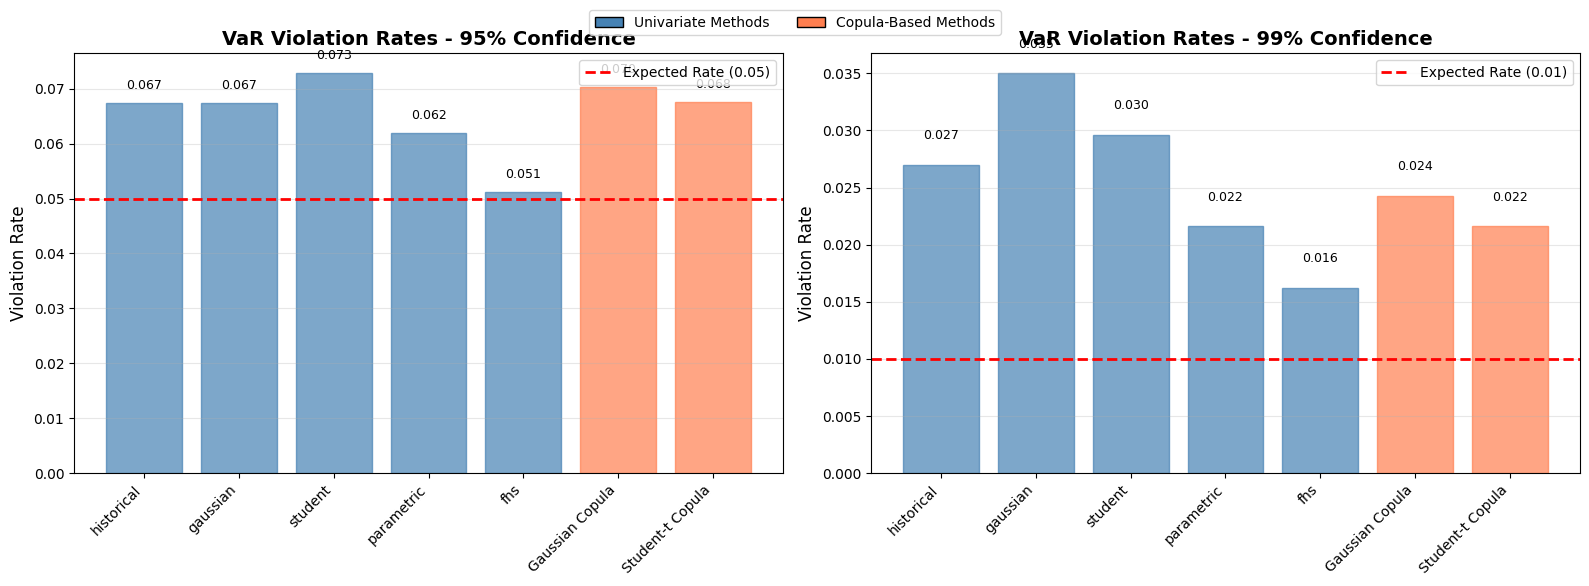

In [52]:
# Visualize violation rates comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, confidence in enumerate(CONFIDENCE):
    ax = axes[i]
    alpha = 1 - confidence
    
    # Filter data for this confidence level
    data = comparison_df[comparison_df['Confidence'] == f"{int(confidence*100)}%"].copy()
    
    # Convert violation rate to float for plotting
    data['Violation Rate Numeric'] = data['Violation Rate'].astype(float)
    data['Method_Full'] = data['Approach'] + ' - ' + data['Method']
    
    # Create bar plot
    x_pos = np.arange(len(data))
    bars = ax.bar(x_pos, data['Violation Rate Numeric'], alpha=0.7, edgecolor='black')
    
    # Color bars by approach
    colors = ['steelblue' if approach == 'Univariate' else 'coral' 
              for approach in data['Approach']]
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add expected rate line
    ax.axhline(y=alpha, color='red', linestyle='--', linewidth=2, label=f'Expected Rate ({alpha:.2f})')
    
    # Formatting
    ax.set_xticks(x_pos)
    ax.set_xticklabels(data['Method'], rotation=45, ha='right')
    ax.set_ylabel('Violation Rate', fontsize=12)
    ax.set_title(f'VaR Violation Rates - {int(confidence*100)}% Confidence', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend()
    
    # Add value labels on bars
    for j, (idx, row) in enumerate(data.iterrows()):
        height = row['Violation Rate Numeric']
        ax.text(j, height + 0.002, f"{height:.3f}", ha='center', va='bottom', fontsize=9)

# Add legend for approaches
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label='Univariate Methods'),
    Patch(facecolor='coral', edgecolor='black', label='Copula-Based Methods')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, frameon=True, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(OUT_DIR / 'portfolio_var_violation_rates.png')
plt.show()

At the 95% confidence level, both Gaussian and Student-*t* copulas exhibit violation rates that exceed the theoretical benchmark, performing similarly to or slightly worse than several univariate methods. At the 99% level, copula models show a modest improvement relative to some univariate approaches; however, their violation rates remain above the expected threshold, indicating persistent underestimation of tail risk.

In contrast, univariate models that account for time-varying volatility, in particular the Filtered Historical Simulation (FHS) and parametric GARCH, achieve violation rates closest to the theoretical expectations across both confidence levels. This suggests that, for our particular portfolio and the period under study, modeling temporal dependence and volatility clustering is more impactful for accurate risk measurement than modeling cross-sectional dependence alone.

In [53]:
def plot_portfolio_var_methods_grid(L_portfolio,
                                    portfolio_rolling_results,
                                    copula_results=None,
                                    methods_univariate=None,
                                    methods_copula=None,
                                    confidences=(0.95, 0.99)):
    """
    Plot portfolio losses vs VaR for each method in a grid:
    one row per method, one column per confidence level.

    Parameters
    ----------
    L_portfolio : pd.Series
        Portfolio losses time series (e.g., L_portfolio = -portfolio_returns).
    portfolio_rolling_results : dict-like
        Output of rolling_forecast for the portfolio, indexed as:
        portfolio_rolling_results[method]['VaR'][confidence].
    copula_results : dict, optional
        Output of copula_portfolio_var_es, with keys 'gaussian' and 'student',
        accessed as copula_results[copula_type]['VaR'][confidence].
    methods_univariate : list of str, optional
        List of univariate method names to include, e.g.
        ["historical", "fhs", "gaussian", "student", "parametric"].
    methods_copula : list of str, optional
        List of copula method keys, subset of ["gaussian", "student"].
    confidences : iterable of float
        Confidence levels to plot (e.g., (0.95, 0.99)).
    """

    confidences = list(confidences)
    n_conf = len(confidences)

    if methods_univariate is None:
        methods_univariate = list(portfolio_rolling_results.keys())

    if (copula_results is not None) and (methods_copula is None):
        methods_copula = ["gaussian", "student"]
    elif copula_results is None:
        methods_copula = []

    # Build list of (source_type, key, label)
    # source_type: 'univariate' or 'copula'
    method_list = []

    # Univariate methods
    for method in methods_univariate:
        method_list.append(("univariate", method, f"Univariate - {method}"))

    # Copula methods
    for cop in methods_copula:
        label = "Gaussian Copula" if cop == "gaussian" else "Student-t Copula"
        method_list.append(("copula", cop, label))

    n_methods = len(method_list)
    if n_methods == 0:
        print("No methods provided to plot.")
        return

    fig, axes = plt.subplots(
        n_methods, n_conf,
        figsize=(6 * n_conf, 3 * n_methods),
        sharex=True
    )

    # Ensure axes is 2D
    if n_methods == 1 and n_conf == 1:
        axes = np.array([[axes]])
    elif n_methods == 1:
        axes = axes.reshape(1, -1)
    elif n_conf == 1:
        axes = axes.reshape(-1, 1)

    for i, (src_type, key, base_label) in enumerate(method_list):
        for j, conf in enumerate(confidences):
            ax = axes[i, j]

            # Get VaR series for this method & confidence
            if src_type == "univariate":
                VaR_series = portfolio_rolling_results[key]["VaR"][conf].dropna()
            else:  # copula
                VaR_series = copula_results[key]["VaR"][conf].dropna()

            # Align portfolio loss with VaR series
            common_idx = L_portfolio.index.intersection(VaR_series.index)
            L_aligned = L_portfolio.loc[common_idx]
            V_aligned = VaR_series.loc[common_idx]

            # Plot full loss series (context)
            ax.plot(
                L_portfolio.index, L_portfolio.values,
                color="black", alpha=0.35, linewidth=0.9,
                label="Portfolio Loss"
            )

            # Plot VaR
            ax.plot(
                V_aligned.index, V_aligned.values,
                linewidth=1.6,
                label=f"{base_label} VaR ({int(conf*100)}%)"
            )

            # Violations
            violations = L_aligned > V_aligned
            ax.scatter(
                L_aligned[violations].index,
                L_aligned[violations].values,
                color="red", marker="x", s=50,
                label="Violations"
            )

            # Labels / titles
            if j == 0:
                ax.set_ylabel("Loss / VaR", fontsize=11)
            ax.set_title(
                f"{base_label} - {int(conf*100)}%",
                fontsize=13, fontweight="bold"
            )

            # Grid & legend
            ax.grid(alpha=0.3)
            ax.legend(fontsize=8, loc="upper left")

            # Date formatting: only bottom row shows tick labels
            if i == n_methods - 1:
                ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            else:
                ax.set_xticklabels([])

    fig.suptitle(
        "Portfolio Rolling VaR vs Realized Losses\nMethods x Confidence Levels",
        fontsize=16, fontweight="bold",
        y=0.995   # move title closer to the top
    )
    plt.tight_layout(pad=1.0)  # reduce padding between title and axes
    fig.subplots_adjust(top=0.95)  # key line: moves plots upward
    plt.savefig(OUT_DIR / 'portfolio_var_portfolio_methods.png')
    plt.show()

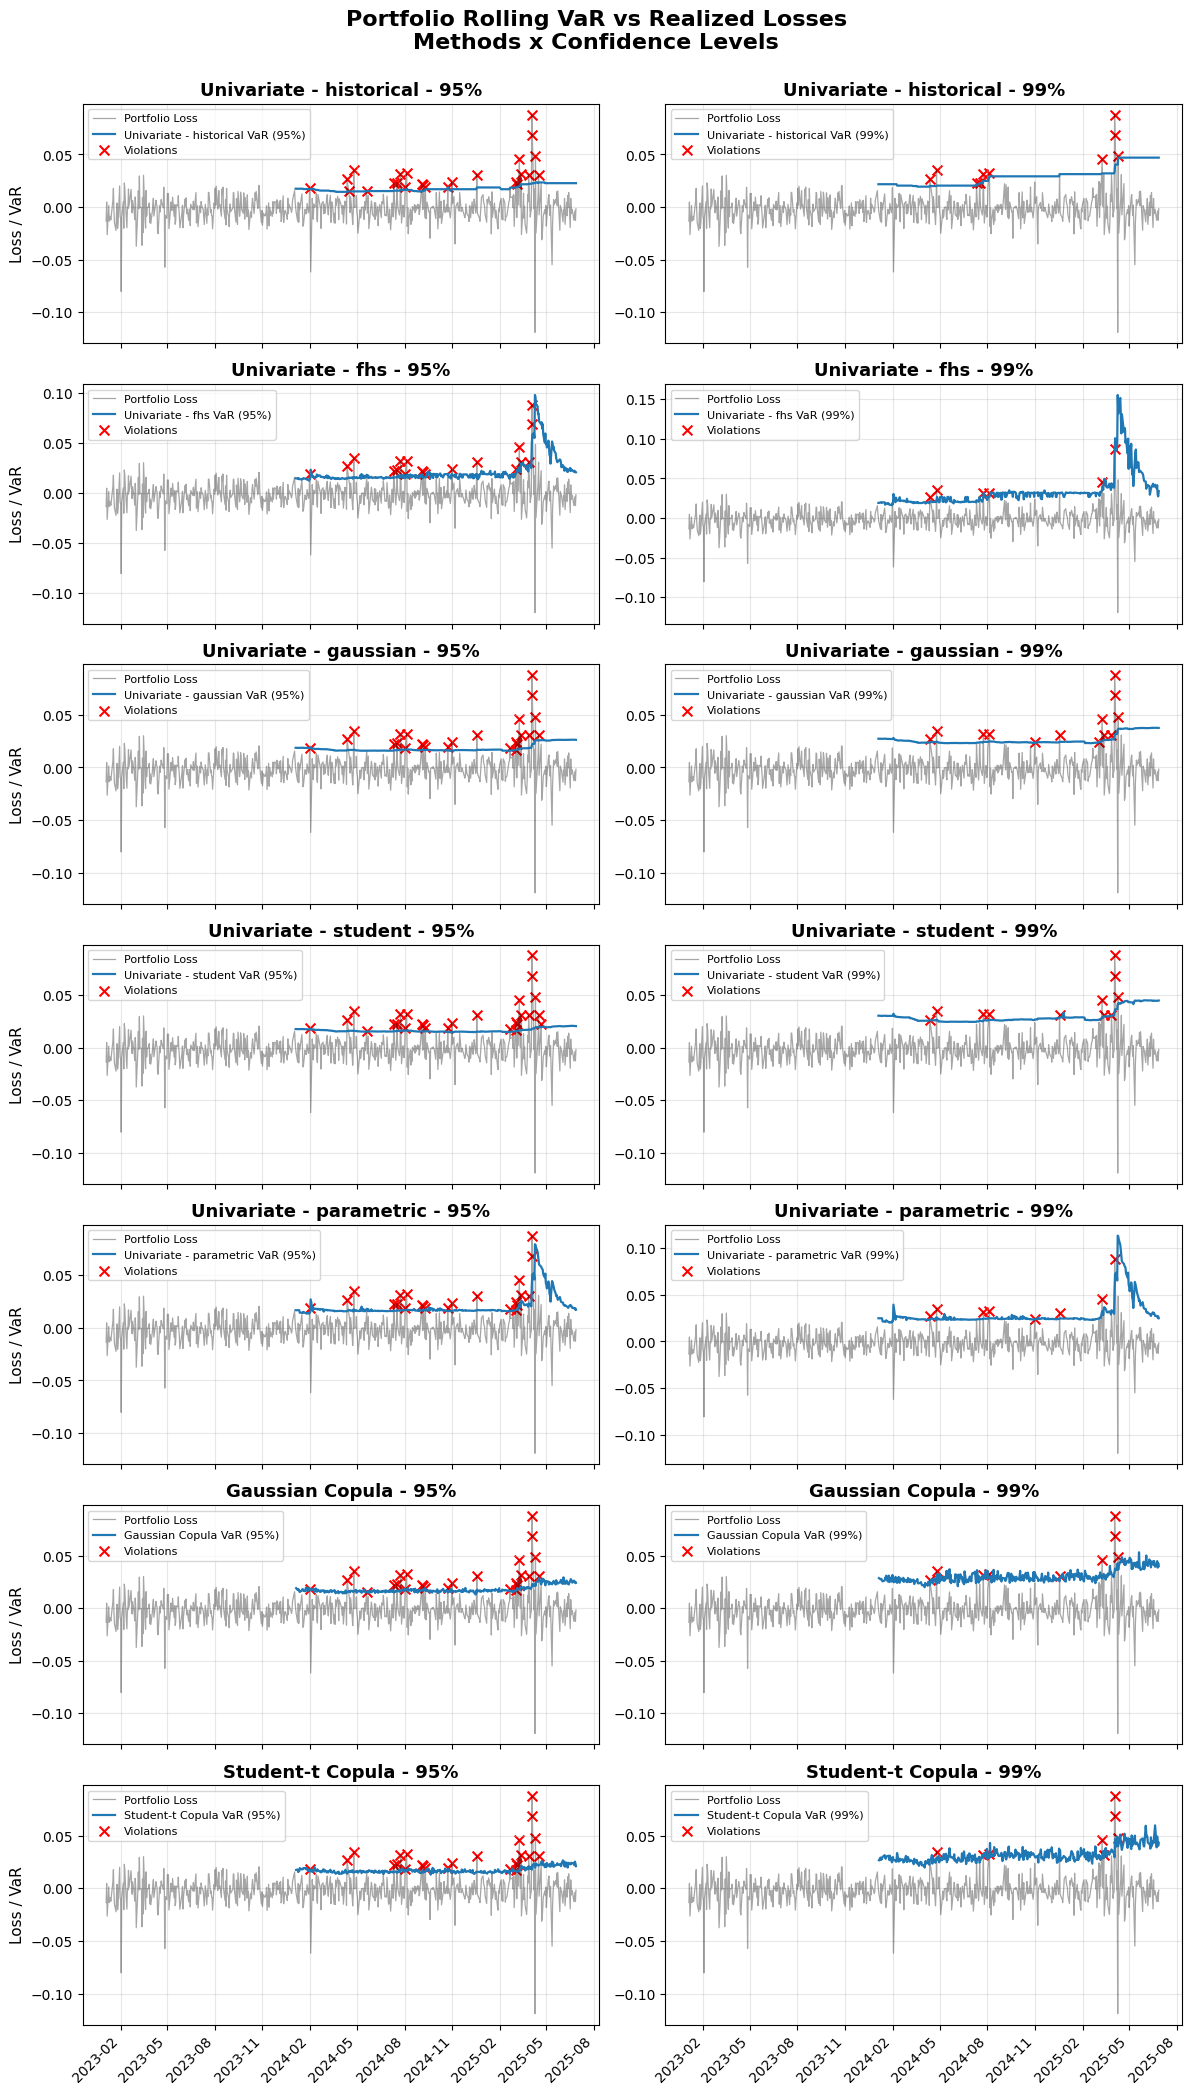

In [54]:
methods_univariate = ["historical", "fhs", "gaussian", "student", "parametric"]
methods_copula = ["gaussian", "student"]  # keys in copula_results

plot_portfolio_var_methods_grid(
    L_portfolio=L_portfolio,
    portfolio_rolling_results=portfolio_rolling_results,
    copula_results=copula_results,
    methods_univariate=methods_univariate,
    methods_copula=methods_copula,
    confidences=(0.95, 0.99)
)

The figure presents the realized portfolio losses alongside the Value-at-Risk (VaR) estimates produced by different methods, at both **95%** and **99%** confidence levels. Red crosses indicate violations instances where the realized loss exceeds the forecasted VaR. These plots help assess the temporal behavior, responsiveness, and adequacy of each risk model.

A well-calibrated VaR model should:

- Adjust dynamically to changing market volatility,
- Anticipate periods of elevated risk,
- Produce violations at a frequency consistent with the chosen confidence level (≈5% or 1%),
- Avoid large clusters of violations during stress periods.

A visual inspection reveals that copula-based approaches do not systematically outperform univariate models such as FHS or GARCH-type specifications. Although copulas provide a more flexible framework to model cross-sectional dependence, their VaR curves often remain too smooth and fail to adjust rapidly during periods of heightened volatility. As a result, copula-based VaR estimates are frequently exceeded during market stress, leading to a substantial number of violations.

In contrast, univariate methods that explicitly incorporate time-varying volatility, particularly FHS, tend to align more closely with the observed loss dynamics. These models react more promptly to volatility bursts and adjust their risk estimates accordingly, which explains their lower violation frequencies. This behavior is especially visible during the sharp increase in losses towards the end of the sample: while FHS-based VaR rapidly escalates to reflect the changing risk environment, copula-based VaR remains comparatively muted and is repeatedly breached.

In [55]:
def plot_portfolio_es_methods_grid(L_portfolio,
                                   portfolio_rolling_results,
                                   copula_results=None,
                                   methods_univariate=None,
                                   methods_copula=None,
                                   confidences=(0.95, 0.99)):
    """
    Plot portfolio losses vs ES for each method in a grid:
    one row per method, one column per confidence level.

    Parameters
    ----------
    L_portfolio : pd.Series
        Portfolio losses time series (e.g., L_portfolio = -portfolio_returns).
    portfolio_rolling_results : dict-like
        Output of rolling_forecast for the portfolio, indexed as:
        portfolio_rolling_results[method]['ES'][confidence].
    copula_results : dict, optional
        Output of copula_portfolio_var_es, with keys 'gaussian' and 'student',
        accessed as copula_results[copula_type]['ES'][confidence].
    methods_univariate : list of str, optional
        List of univariate method names to include, e.g.
        ["historical", "fhs", "gaussian", "student", "parametric"].
    methods_copula : list of str, optional
        List of copula method keys, subset of ["gaussian", "student"].
    confidences : iterable of float
        Confidence levels to plot (e.g., (0.95, 0.99)).
    """

    confidences = list(confidences)
    n_conf = len(confidences)

    if methods_univariate is None:
        methods_univariate = list(portfolio_rolling_results.keys())

    if (copula_results is not None) and (methods_copula is None):
        methods_copula = ["gaussian", "student"]
    elif copula_results is None:
        methods_copula = []

    # Build list of (source_type, key, label)
    method_list = []

    # Univariate methods
    for method in methods_univariate:
        method_list.append(("univariate", method, f"Univariate - {method}"))

    # Copula methods
    for cop in methods_copula:
        label = "Gaussian Copula" if cop == "gaussian" else "Student-t Copula"
        method_list.append(("copula", cop, label))

    n_methods = len(method_list)
    if n_methods == 0:
        print("No methods provided to plot.")
        return

    fig, axes = plt.subplots(
        n_methods, n_conf,
        figsize=(6 * n_conf, 3 * n_methods),
        sharex=True
    )

    # Ensure axes is 2D
    if n_methods == 1 and n_conf == 1:
        axes = np.array([[axes]])
    elif n_methods == 1:
        axes = axes.reshape(1, -1)
    elif n_conf == 1:
        axes = axes.reshape(-1, 1)

    for i, (src_type, key, base_label) in enumerate(method_list):
        for j, conf in enumerate(confidences):
            ax = axes[i, j]

            # Get ES series for this method & confidence
            if src_type == "univariate":
                ES_series = portfolio_rolling_results[key]["ES"][conf].dropna()
            else:  # copula
                ES_series = copula_results[key]["ES"][conf].dropna()

            # Align portfolio loss with ES series
            common_idx = L_portfolio.index.intersection(ES_series.index)
            L_aligned = L_portfolio.loc[common_idx]
            ES_aligned = ES_series.loc[common_idx]

            # Plot full loss series (context)
            ax.plot(
                L_portfolio.index, L_portfolio.values,
                color="black", alpha=0.35, linewidth=0.9,
                label="Portfolio Loss"
            )

            # Plot ES
            ax.plot(
                ES_aligned.index, ES_aligned.values,
                linewidth=1.6, linestyle="--",
                label=f"{base_label} ES ({int(conf*100)}%)"
            )

            # Violations: loss > ES
            violations = L_aligned > ES_aligned
            ax.scatter(
                L_aligned[violations].index,
                L_aligned[violations].values,
                color="red", marker="x", s=50,
                label="Loss > ES"
            )

            # Labels / titles
            if j == 0:
                ax.set_ylabel("Loss / ES", fontsize=11)
            ax.set_title(
                f"{base_label} - {int(conf*100)}%",
                fontsize=13, fontweight="bold"
            )

            # Grid & legend
            ax.grid(alpha=0.3)
            ax.legend(fontsize=8, loc="upper left")

            # Date formatting: only bottom row shows tick labels
            if i == n_methods - 1:
                ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            else:
                ax.set_xticklabels([])

    fig.suptitle(
        "Portfolio Rolling ES vs Realized Losses\nMethods x Confidence Levels",
        fontsize=16, fontweight="bold",
        y=0.995   # move title closer to the top
    )
    plt.tight_layout(pad=1.0)
    fig.subplots_adjust(top=0.95)
    plt.savefig(OUT_DIR / 'portfolio_es_portfolio_methods.png')
    plt.show()

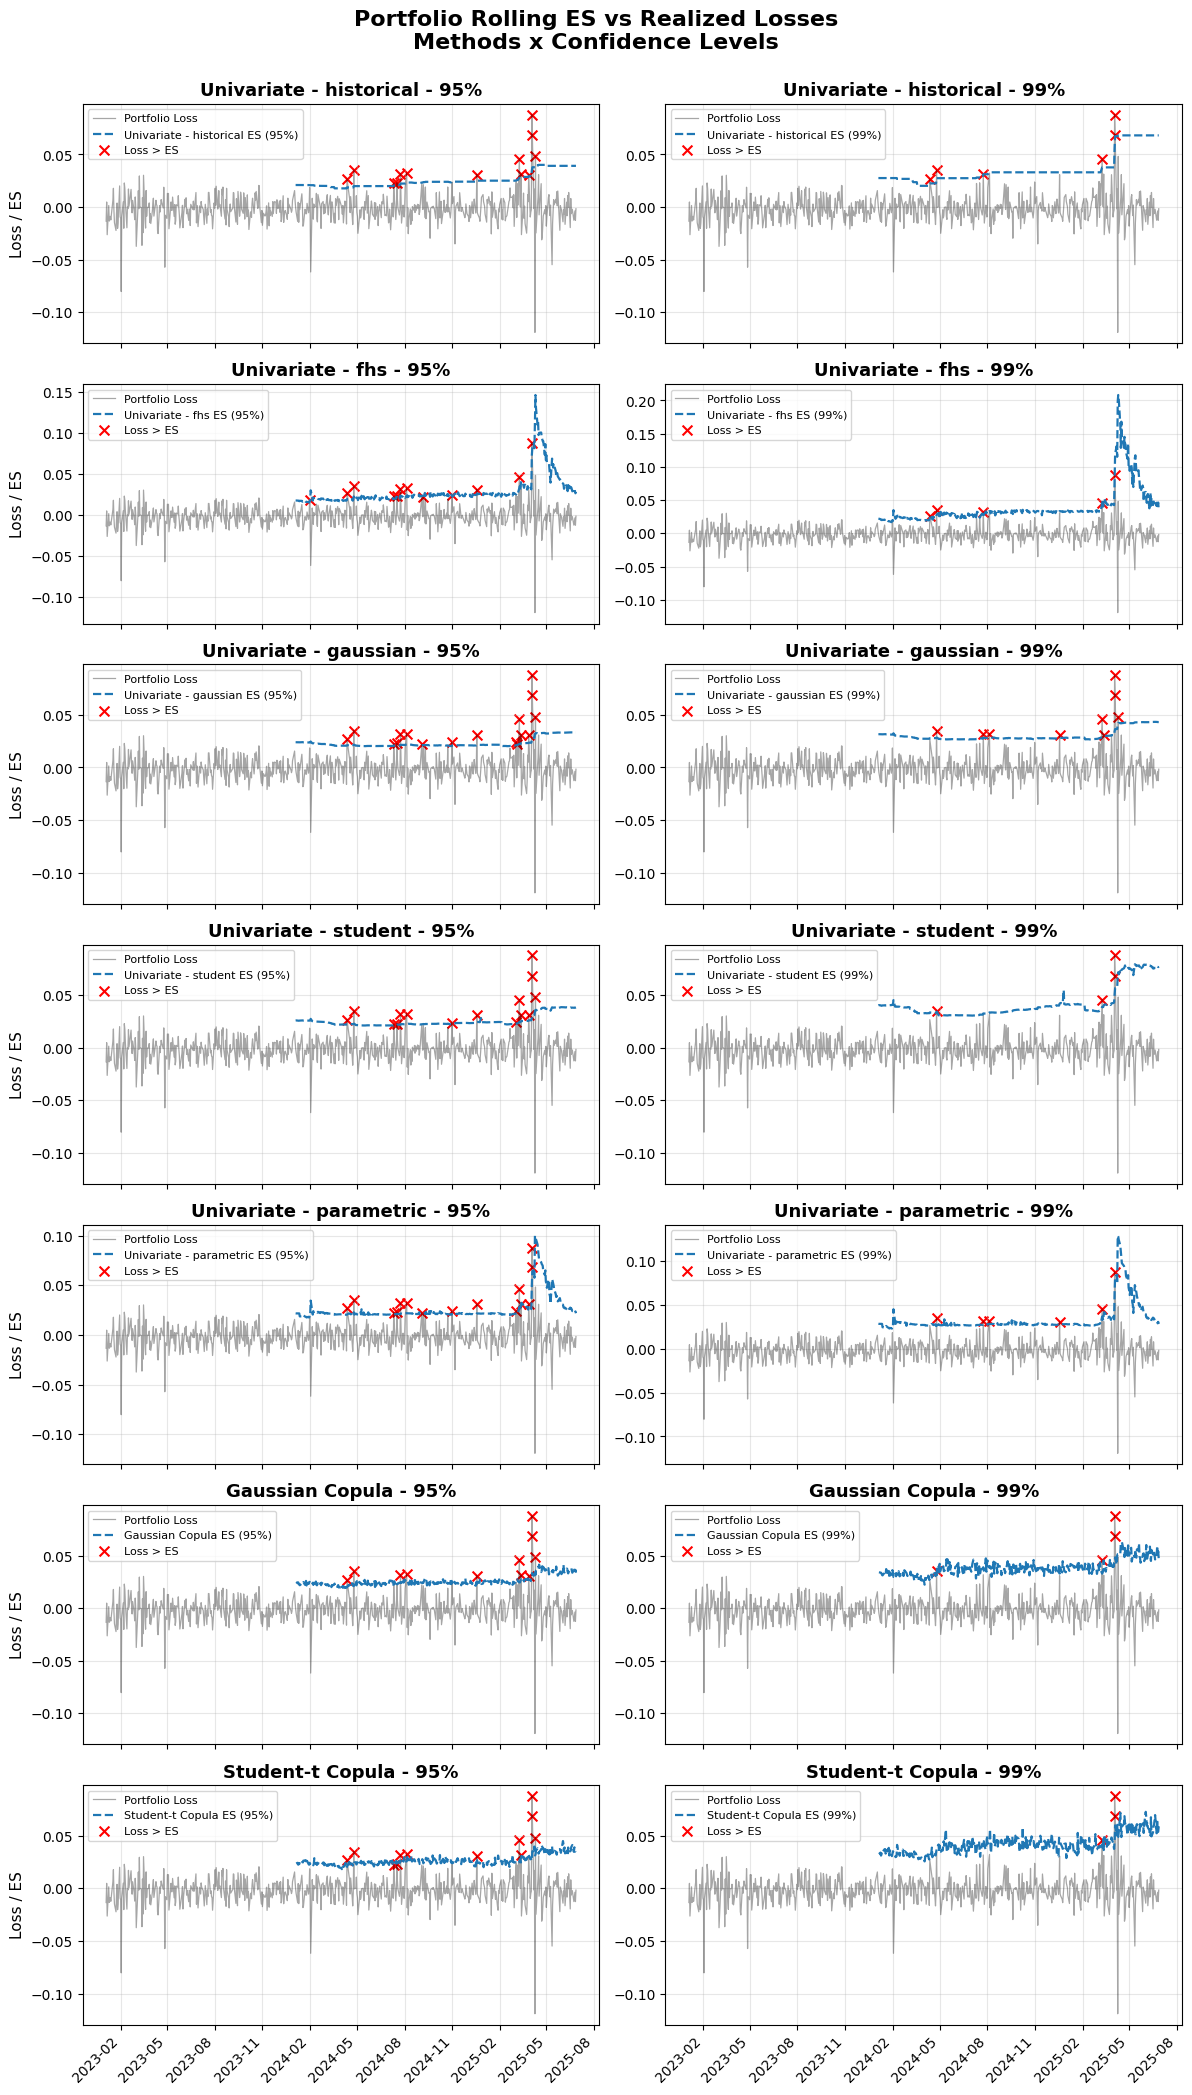

In [56]:
methods_univariate = ["historical", "fhs", "gaussian", "student", "parametric"]
methods_copula = ["gaussian", "student"]  # keys in copula_results

plot_portfolio_es_methods_grid(
    L_portfolio=L_portfolio,
    portfolio_rolling_results=portfolio_rolling_results,
    copula_results=copula_results,
    methods_univariate=methods_univariate,
    methods_copula=methods_copula,
    confidences=(0.95, 0.99)
)

Expected Shortfall (ES) measures the *average loss* in the tail beyond the VaR threshold. A well-calibrated ES model should therefore:

- **Consistently exceed realized losses** during normal periods, since ES is a *worst-case conditional loss*,
- **Increase sharply during market stress**, capturing escalating downside risk,
- **Avoid repeated exceedances**—losses should only rarely be higher than ES,
- Reflect changes in **both volatility and dependence** across assets, since ES is highly sensitive to tail co-movements.

In short, ES should form a **protective upper boundary** for losses in extreme conditions. If losses frequently cross above ES, the model is underestimating tail risk.

These plots above compare realized portfolio losses with Expected Shortfall (ES) forecasts from different univariate and copula-based models at **95%** and **99%** confidence levels. Red crosses indicate instances where losses exceed the ES estimate.

Similar to the VaR analysis, the copula-based approaches do not demonstrate a clear performance advantage over univariate methods. Although ES is a coherent risk measure and theoretically more sensitive to tail events, the copula-based ES estimates remain relatively stable throughout the sample and fail to escalate during periods of heightened market stress. Consequently, several realized losses exceed the copula-based ES thresholds, indicating that these models tend to underestimate tail risk.

By contrast, univariate models that incorporate time-varying volatility, particularly the Filtered Historical Simulation (FHS) and, to a lesser extent, parametric GARCH-type, provide more reactive ES estimates. These methods adjust rapidly to volatility bursts, producing higher ES values when market conditions deteriorate. This dynamic behavior results in fewer ES breaches, especially in the latter part of the sample, where the portfolio experiences the most extreme losses. The responsiveness of FHS to evolving volatility patterns highlights the importance of modeling temporal dependence and volatility clustering when forecasting downside risk.

## Conclusion

The objective of this analysis was to assess whether dependence modeling improves portfolio risk estimation. While copula-based approaches explicitly capture the cross-sectional dependence structure between assets, the empirical results do not provide clear evidence of superior performance compared to univariate models.

An explanation for these findings lies in the characteristics of the underlying portfolio. The three assets considered do not exhibit pronounced dependence, which limits the potential gains from employing copula-based models. In such a context, explicitly modeling cross-sectional dependence offers little improvement. Moreover, copulas do not account for volatility clustering or sudden volatility bursts if we give them simple Gaussian or Student-$t$ marginals, unlike FHS and GARCH. Since extreme losses during the sample period appear to be primarily driven by volatility dynamics rather than dependence structures, correctly modeling time-varying volatility proves more important than capturing marginal dependence. Consequently, the relative underperformance of copula-based methods is consistent with the underlying data-generating process and the nature of the portfolio risk.

Therefore, we cannot conclude that dependence modeling via copulas systematically improves the results. Copula-based methods do not outperform well-specified univariate models such as FHS, and their benefits become visible only at extreme confidence levels without consistently translating into better backtesting outcomes. While copulas generally perform better than some simpler univariate approaches, this incremental improvement remains insufficient to claim superiority over methods that explicitly model volatility dynamics. As a result, the evidence does not support the claim that copulas provide superior VaR or ES estimates in this setting.